In [1]:
import pandas as pd
import numpy as np
import os
import nibabel as nib
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from utils import flatten
from utils import DataLoader2DT1GD ## the 2D one with slices t1_gd
from utils import DataLoader2DALL ## the 2D one with slices of t1_gd, flair and pre_gd
from utils import DataLoader2 ## no slices and all the modes
from utils import CustomDataset
from utils import visualize_slices
from utils import train_validate_model
from utils import multiclass_roc_auc_score
from utils import class_vs_rest_roc_auc_score
from utils import calculate_specificity
from utils import calculate_sensitivity
from utils import calculate_f1_score
from utils import calculate_accuracy
from utils import calculate_precision
from imblearn.over_sampling import SMOTE
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet50, ResNet50_Weights
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision.models import resnet50, ResNet50_Weights
from tqdm import tqdm
from utils import test_model
from sklearn.metrics import confusion_matrix
import torchvision.transforms as T
import torchio
from torchio.transforms import (
    CropOrPad,
    OneOf,
    RescaleIntensity,
    RandomAffine,
    RandomElasticDeformation,
    RandomFlip,
    Compose,
)
from sklearn.utils.class_weight import compute_class_weight
from efficientnet_pytorch import EfficientNet


In [2]:
df = pd.read_excel('all_patients.xlsx')
df = df[df.shape_VoxelVolume > 125]
df.drop(df[df['labels'] == 3].index, inplace = True) ## dropping label of the call OTHERS
df.drop(df[df['number_annotations'] > 1].index, inplace = True)
df

,subjid,label,shape_Elongation,shape_Flatness,shape_LeastAxisLength,shape_MajorAxisLength,shape_Maximum2DDiameterColumn,shape_Maximum2DDiameterRow,shape_Maximum2DDiameterSlice,shape_Maximum3DDiameter,...,ngtdm_Busyness,ngtdm_Coarseness,ngtdm_Complexity,ngtdm_Contrast,ngtdm_Strength,Age,number_annotations,F,M,labels
0,Oslo01,1,0.829356,0.682981,8.512717,12.464063,14.866069,14.560220,12.529964,15.394804,...,158.977235,0.008929,0.302273,0.074659,0.008950,58,1,0,1,0
1,Oslo01,2,0.944143,0.900681,14.133927,15.692487,17.804494,19.416488,18.681542,19.467922,...,39.445794,0.007407,0.115448,0.010426,0.007130,58,1,0,1,0
4,Oslo02,4,0.849295,0.841082,8.703783,10.348315,10.816654,11.704700,11.704700,12.449900,...,14.239428,0.022868,0.159307,0.020316,0.023465,50,1,1,0,1
5,Oslo02,5,0.939828,0.821847,12.093804,14.715396,17.262677,17.888544,17.492856,18.000000,...,49.609354,0.008536,0.137901,0.028455,0.008212,50,1,1,0,1
7,Oslo03,1,0.930698,0.629604,10.914986,17.336268,20.615528,18.439089,19.416488,20.712315,...,43.648474,0.007781,0.123220,0.017415,0.007982,64,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2408,Stan_328,1,0.810571,0.325076,8.769420,26.976501,31.384710,28.160256,27.459060,33.075671,...,12.988427,0.019891,0.030104,0.000639,0.019768,53,1,0,1,1
2415,Stan_328,8,0.967496,0.597282,6.131668,10.265944,11.661904,12.369317,12.165525,12.688578,...,18.452502,0.024791,0.208465,0.046975,0.023205,53,1,0,1,1
2418,Stan_328,11,0.561746,0.506390,5.004740,9.883181,8.246211,11.704700,10.000000,12.124356,...,0.553323,0.468447,0.025263,0.000748,0.365681,53,1,0,1,1
2419,Stan_328,12,0.959775,0.756903,5.164755,6.823538,7.615773,8.602325,8.602325,8.602325,...,0.000000,1000000.000000,0.000000,0.000000,0.000000,53,1,0,1,1


## we have created a new folder called deep learning with all the folder with all the folder per patient labels as 0, 1 or 2 with tumors greater than 125mm3

In [3]:
df2 = df[['subjid']].join(df['label']).join(df['labels'])
#df2.to_excel('final_labels.xlsx')
df2

,subjid,label,labels
0,Oslo01,1,0
1,Oslo01,2,0
4,Oslo02,4,1
5,Oslo02,5,1
7,Oslo03,1,0
...,...,...,...
2408,Stan_328,1,1
2415,Stan_328,8,1
2418,Stan_328,11,1
2419,Stan_328,12,1


In [4]:
new_df = pd.DataFrame({'Subjid': df.iloc[:, 0], 'Tumor': df.iloc[:, 1], 'Labels': df.iloc[:, -1]})
new_df = new_df.drop_duplicates(subset='Subjid', keep='first')
new_df = new_df[new_df['Subjid'] != 'Oslo66']
y_patients = new_df['Labels']

In [5]:
df3 = pd.read_excel('final_labels.xlsx')
df3.set_index('subjid')
y = df3['labels']
len(y)

437

## lets see if the slices thing work

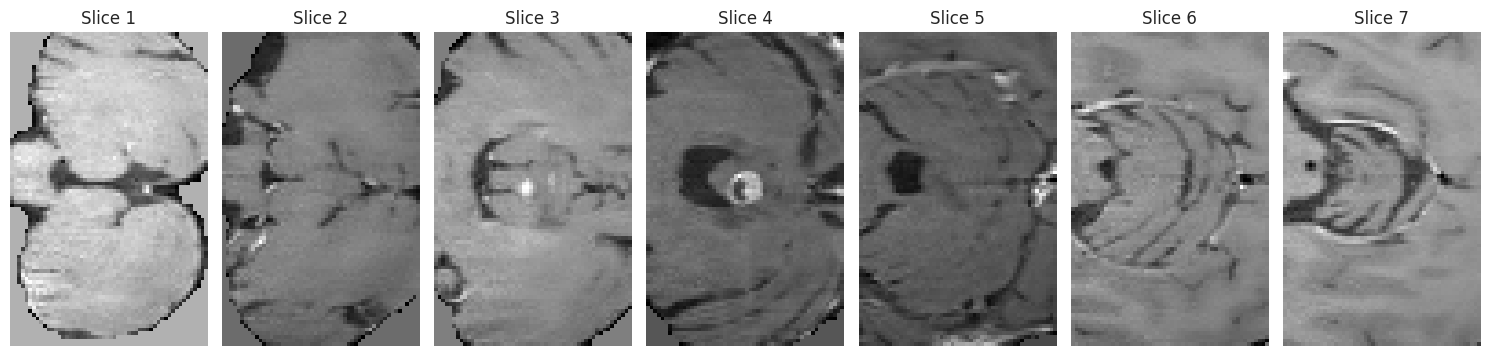

In [10]:
img_dir = f'/data/projects/TMOR/data/VeryFinalA/Oslo02/4/t1_gd.nii.gz'

visualize_slices(img_dir)

## 2D T1GD

In [41]:
scores = {'acc': [], 'SD_acc': [], 'CI_acc': [], 'auc_tot': [], 'SD_auc_tot': [], 'CI_auc_tot': [], 'auc_class': [], 'SD_auc_class': [], 'CI_auc_class': [], 'Sen_mean': [], 'Sen_CI': [], 'Sen_SD': [], 'Spe_mean': [], 'Spe_CI': [], 'Spe_sd': [], 'Pre_mean': [], 'Pre_CI': [], 'Pre_sd': [], 'F1_mean': [], 'F1_CI': [], 'F1_sd': [], 'Accy_mean': [], 'Accy_CI': [], 'Accy_sd': []}

num_classes = len(np.unique(y))
sum_confusion_matrix_rf = np.zeros((num_classes, num_classes))

data_loader = DataLoader2DT1GD()

# Splitting into train, validation, and test sets
unique_patients = list(new_df['Subjid'])


# Splitting unique_patient_ids into trainval and test patient IDs
trainval_patient_ids, test_patient_ids = train_test_split(unique_patients, test_size=0.2, random_state=0, stratify = y_patients)

trainval_y = [new_df[new_df['Subjid'] == i]['Labels'].values[0] for i in trainval_patient_ids]

# Perform stratified shuffle split on train indices
#kf = KFold(n_splits=5, random_state=42, shuffle=True)
sss = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
#sss = StratifiedShuffleSplit(n_splits=5, test_size=0.25, random_state=42)
for train_index, val_index in sss.split(trainval_patient_ids, trainval_y):
    fold_acc = []
    fold_auc_tot = []
    fold_auc_class = []
    sensi = []
    speci = []
    prec = []
    f1 = []
    accy = []
    features = []
    p_value = []
    feat = []
    value = []
    ######## training #########################################################
    train_patients = [trainval_patient_ids[i] for i in train_index]
    training_tumors = flatten([df3[df3['subjid'] == s].index for s in train_patients])
    X_train, y_train = data_loader[training_tumors]
    #num_samples, channels, height, width = X_train.shape
    #X_train_reshaped = X_train.reshape((num_samples, channels * height * width))
    #X_train_np = np.array(X_train_reshaped)
    #y_train_np = np.array(y_train)

    # Apply SMOTE-ENN resampling
    #sm = SMOTE(sampling_strategy='not majority')
    #X_resampled_np, y_resampled_np = sm.fit_resample(X_train_np, y_train_np)

    #X_train_resampled = X_resampled_np.reshape((X_resampled_np.shape[0],channels, height, width))
    #X_train_resampled = torch.Tensor(X_train_resampled)
    #y_train_resampled = y_resampled_np

    ########## validation ############################################################
    val_patients = [trainval_patient_ids[i] for i in val_index]
    val_tumors = flatten([df3[df3['subjid'] == s].index for s in val_patients])
    X_val, y_val = data_loader[val_tumors]

    ######## test ############################################################################
    test_tumors = flatten([df3[df3['subjid'] == s].index for s in test_patient_ids])
    X_test, y_test = data_loader[test_tumors]

    #### set class weights to account for imbalanced dataset
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

    ## Rescaling
    #rescale = RescaleIntensity((0.05, 99.5))
    #randaffine = torchio.RandomAffine(scales=(0.9,1.2),degrees=10, isotropic=True, image_interpolation='nearest')
    #flip = torchio.RandomFlip(axes=('LR'), p=0.5)
    #transforms = [flip, randaffine]
    #transform = Compose(transforms)

    train_transform = T.Compose([
        T.RandomHorizontalFlip(0.5),
        T.RandomVerticalFlip(0.5),
        T.RandomRotation(degrees=15)
        ])

    model = resnet50(weights = ResNet50_Weights.IMAGENET1K_V2)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=5, bias=False)
    model.fc = nn.Linear(2048, 3)

    criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weights))
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Convert data to TensorDataset
    train_dataset = CustomDataset(X_train, y_train, transform = train_transform)
    val_dataset = CustomDataset(X_val, y_val)
    test_dataset = CustomDataset(X_test, y_test)

    batch_size = 32
    num_epochs = 30
    patience = 2
    path=f'checkpoint_ResNet50_2D(2).pt'
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    print('TRAINING')
    train_validate_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, patience, path=path)

    model.load_state_dict(torch.load(f'checkpoint_ResNet50_2D(2).pt'))
    print('TESTING')
    test_model(model, test_loader, criterion)
    y_pred = test_model(model, test_loader, criterion)

    accuracy = accuracy_score(y_test, y_pred)
    num_classes = len(np.unique(y_test))
    cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))
    specificity = calculate_specificity(cm)
    sensitivity = calculate_sensitivity(cm)
    precision = calculate_precision(cm)
    F1 = calculate_f1_score(cm)
    Accy = calculate_accuracy(cm)
    sum_confusion_matrix_rf += cm
    break


TRAINING


Training Progress:   0%|          | 0/30 [00:00<?, ?it/s]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [1/30]: Train Loss: 0.8585 | Val Loss: 1.0195 | Val Acc: 33.33%
Validation loss decreased (inf --> 1.019486).  Saving model ...


Training Progress:   3%|▎         | 1/30 [01:35<46:04, 95.34s/it]


KeyboardInterrupt: 

## EfficientNet

In [7]:
model_name = 'efficientnet-b0'

# Create the EfficientNet model
model = EfficientNet.from_pretrained('efficientnet-b0')

Loaded pretrained weights for efficientnet-b0


In [11]:
scores = {'acc': [], 'SD_acc': [], 'CI_acc': [], 'auc_tot': [], 'SD_auc_tot': [], 'CI_auc_tot': [], 'auc_class': [], 'SD_auc_class': [], 'CI_auc_class': [], 'Sen_mean': [], 'Sen_CI': [], 'Sen_SD': [], 'Spe_mean': [], 'Spe_CI': [], 'Spe_sd': [], 'Pre_mean': [], 'Pre_CI': [], 'Pre_sd': [], 'F1_mean': [], 'F1_CI': [], 'F1_sd': [], 'Accy_mean': [], 'Accy_CI': [], 'Accy_sd': []}

num_classes = len(np.unique(y))
sum_confusion_matrix_rf = np.zeros((num_classes, num_classes))

data_loader = DataLoader2DT1GD()

# Splitting into train, validation, and test sets
unique_patients = list(new_df['Subjid'])


# Splitting unique_patient_ids into trainval and test patient IDs
trainval_patient_ids, test_patient_ids = train_test_split(unique_patients, test_size=0.2, random_state=0, stratify = y_patients)

trainval_y = [new_df[new_df['Subjid'] == i]['Labels'].values[0] for i in trainval_patient_ids]

# Perform stratified shuffle split on train indices
#kf = KFold(n_splits=5, random_state=42, shuffle=True)
sss = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)
#sss = StratifiedShuffleSplit(n_splits=5, test_size=0.25, random_state=42)
fold_acc = []
fold_auc_tot = []
fold_auc_class = []
sensi = []
speci = []
prec = []
f1 = []
accy = []
for train_index, val_index in sss.split(trainval_patient_ids, trainval_y):
    ######## training #########################################################
    train_patients = [trainval_patient_ids[i] for i in train_index]
    training_tumors = flatten([df3[df3['subjid'] == s].index for s in train_patients])
    X_train, y_train = data_loader[training_tumors]
    ########## validation ############################################################
    val_patients = [trainval_patient_ids[i] for i in val_index]
    val_tumors = flatten([df3[df3['subjid'] == s].index for s in val_patients])
    X_val, y_val = data_loader[val_tumors]

    ######## test ############################################################################
    test_tumors = flatten([df3[df3['subjid'] == s].index for s in test_patient_ids])
    X_test, y_test = data_loader[test_tumors]

    #### set class weights to account for imbalanced dataset
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

    ## Rescaling
    #rescale = RescaleIntensity((0.05, 99.5))
    #randaffine = torchio.RandomAffine(scales=(0.9,1.2),degrees=10, isotropic=True, image_interpolation='nearest')
    #flip = torchio.RandomFlip(axes=('LR'), p=0.5)
    #transforms = [flip, randaffine]
    #transform = Compose(transforms)

    train_transform = T.Compose([
    T.RandomHorizontalFlip(0.5),
    T.RandomVerticalFlip(0.5),
    T.RandomRotation(degrees=15),
    T.CenterCrop(size=150)])

    model = EfficientNet.from_pretrained('efficientnet-b0')
    model._conv_stem.in_channels = 1
    #model._conv_stem.weight = torch.mean(model._conv_stem.weight, axis = 1, keepdim=True)
    weights = torch.mean(model._conv_stem.weight, axis=1, keepdim=True)
    model._conv_stem.weight = torch.nn.Parameter(weights)
    #model._conv_stem.weight = torch.nn.Parameter(torch.cat([model._conv_stem.weight, model._conv_stem.weight], axis=1))
    model._fc = nn.Linear(in_features=1280, out_features=3, bias=True)

    criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weights))
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Convert data to TensorDataset
    train_dataset = CustomDataset(X_train, y_train, transform = train_transform)
    val_dataset = CustomDataset(X_val, y_val, transform = train_transform)
    test_dataset = CustomDataset(X_test, y_test)

    batch_size = 32
    num_epochs = 50
    patience = 10
    path=f'checkpoint_EfficientNet.pt'
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    print('TRAINING')
    train_validate_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, patience, path=path)

    model.load_state_dict(torch.load(path))
    y_pred = test_model(model, test_loader, criterion)

    accuracy = accuracy_score(y_test, y_pred)
    num_classes = len(np.unique(y_test))
    cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))
    print(cm)
    specificity = calculate_specificity(cm)
    sensitivity = calculate_sensitivity(cm)
    precision = calculate_precision(cm)
    F1 = calculate_f1_score(cm)
    Accuracy = calculate_accuracy(cm)
    sum_confusion_matrix_rf += cm

    #accuracy = accuracy_score(y_test, y_pred)
    fold_acc.append(accuracy)

    # Calculate AUC score
    auc_tot = multiclass_roc_auc_score(y_test, y_pred)
    fold_auc_tot.append(auc_tot)

    auc_class = class_vs_rest_roc_auc_score(y_test, y_pred)
    fold_auc_class.append(auc_class)

    speci.append(specificity)
    sensi.append(sensitivity)
    prec.append(precision)
    f1.append(F1)
    accy.append(Accuracy)

Loaded pretrained weights for efficientnet-b0
TRAINING


Training Progress:   2%|▏         | 1/50 [00:19<16:14, 19.89s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [1/50]: Train Loss: 0.9392 | Val Loss: 1.0726 | Val Acc: 28.89%
Validation loss decreased (inf --> 1.072603).  Saving model ...


Training Progress:   4%|▍         | 2/50 [00:30<11:36, 14.51s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [2/50]: Train Loss: 1.0025 | Val Loss: 1.1199 | Val Acc: 26.67%
EarlyStopping counter: 1 out of 10


Training Progress:   6%|▌         | 3/50 [00:40<09:49, 12.54s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [3/50]: Train Loss: 0.8178 | Val Loss: 0.9033 | Val Acc: 42.22%
Validation loss decreased (1.072603 --> 0.903288).  Saving model ...


Training Progress:   8%|▊         | 4/50 [00:52<09:23, 12.25s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [4/50]: Train Loss: 0.7377 | Val Loss: 0.9502 | Val Acc: 28.89%
EarlyStopping counter: 1 out of 10


Training Progress:  10%|█         | 5/50 [01:08<10:15, 13.68s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [5/50]: Train Loss: 0.4751 | Val Loss: 0.9843 | Val Acc: 35.56%
EarlyStopping counter: 2 out of 10


Training Progress:  12%|█▏        | 6/50 [01:25<10:41, 14.59s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [6/50]: Train Loss: 0.7336 | Val Loss: 1.1915 | Val Acc: 51.11%
EarlyStopping counter: 3 out of 10


Training Progress:  14%|█▍        | 7/50 [01:37<09:49, 13.71s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [7/50]: Train Loss: 0.3742 | Val Loss: 1.8133 | Val Acc: 60.00%
EarlyStopping counter: 4 out of 10


Training Progress:  16%|█▌        | 8/50 [01:46<08:40, 12.39s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [8/50]: Train Loss: 0.5226 | Val Loss: 2.1227 | Val Acc: 55.56%
EarlyStopping counter: 5 out of 10


Training Progress:  18%|█▊        | 9/50 [01:56<07:53, 11.55s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [9/50]: Train Loss: 0.5185 | Val Loss: 1.9966 | Val Acc: 48.89%
EarlyStopping counter: 6 out of 10


Training Progress:  20%|██        | 10/50 [02:07<07:32, 11.31s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [10/50]: Train Loss: 0.4307 | Val Loss: 2.3769 | Val Acc: 51.11%
EarlyStopping counter: 7 out of 10


Training Progress:  22%|██▏       | 11/50 [02:20<07:41, 11.84s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [11/50]: Train Loss: 0.2743 | Val Loss: 1.9315 | Val Acc: 60.00%
EarlyStopping counter: 8 out of 10


Training Progress:  24%|██▍       | 12/50 [02:38<08:40, 13.68s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [12/50]: Train Loss: 0.4674 | Val Loss: 2.1531 | Val Acc: 57.78%
EarlyStopping counter: 9 out of 10


Training Progress:  24%|██▍       | 12/50 [02:49<08:57, 14.16s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [13/50]: Train Loss: 0.3648 | Val Loss: 1.6266 | Val Acc: 35.56%
EarlyStopping counter: 10 out of 10
Early stopping


Test Loss: 0.984067

Test Accuracy of     0: 60% ( 3/ 5)
Test Accuracy of     1: 63% (46/73)
Test Accuracy of     2: 46% ( 6/13)

Test Accuracy (Overall): 60% (55/91)
[[ 3  2  0]
 [12 46 15]
 [ 2  5  6]]
Loaded pretrained weights for efficientnet-b0
TRAINING


Training Progress:   2%|▏         | 1/50 [00:13<11:19, 13.87s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [1/50]: Train Loss: 1.2136 | Val Loss: 1.1450 | Val Acc: 48.39%
Validation loss decreased (inf --> 1.144972).  Saving model ...


Training Progress:   4%|▍         | 2/50 [00:29<11:47, 14.74s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [2/50]: Train Loss: 0.7182 | Val Loss: 1.2116 | Val Acc: 48.39%
EarlyStopping counter: 1 out of 10


Training Progress:   6%|▌         | 3/50 [00:41<10:31, 13.43s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [3/50]: Train Loss: 0.5457 | Val Loss: 1.4173 | Val Acc: 45.16%
EarlyStopping counter: 2 out of 10


Training Progress:   8%|▊         | 4/50 [00:53<10:01, 13.07s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [4/50]: Train Loss: 0.4215 | Val Loss: 1.8629 | Val Acc: 58.06%
EarlyStopping counter: 3 out of 10


Training Progress:  10%|█         | 5/50 [01:06<09:51, 13.13s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [5/50]: Train Loss: 0.3997 | Val Loss: 2.6618 | Val Acc: 54.84%
EarlyStopping counter: 4 out of 10


Training Progress:  12%|█▏        | 6/50 [01:19<09:23, 12.81s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [6/50]: Train Loss: 0.3595 | Val Loss: 2.4492 | Val Acc: 58.06%
EarlyStopping counter: 5 out of 10


Training Progress:  14%|█▍        | 7/50 [01:32<09:25, 13.16s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [7/50]: Train Loss: 0.2162 | Val Loss: 2.4543 | Val Acc: 48.39%
EarlyStopping counter: 6 out of 10


Training Progress:  16%|█▌        | 8/50 [01:46<09:18, 13.29s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [8/50]: Train Loss: 0.2809 | Val Loss: 1.7967 | Val Acc: 48.39%
EarlyStopping counter: 7 out of 10


Training Progress:  18%|█▊        | 9/50 [02:00<09:09, 13.40s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [9/50]: Train Loss: 0.2455 | Val Loss: 4.1015 | Val Acc: 51.61%
EarlyStopping counter: 8 out of 10


Training Progress:  20%|██        | 10/50 [02:13<08:50, 13.26s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [10/50]: Train Loss: 0.1367 | Val Loss: 3.9185 | Val Acc: 48.39%
EarlyStopping counter: 9 out of 10


Training Progress:  20%|██        | 10/50 [02:27<09:48, 14.72s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [11/50]: Train Loss: 0.2349 | Val Loss: 4.9632 | Val Acc: 51.61%
EarlyStopping counter: 10 out of 10
Early stopping


Test Loss: 1.008885

Test Accuracy of     0: 100% ( 5/ 5)
Test Accuracy of     1: 56% (41/73)
Test Accuracy of     2:  0% ( 0/13)

Test Accuracy (Overall): 50% (46/91)
[[ 5  0  0]
 [28 41  4]
 [ 3 10  0]]


/home/amillanruiz/PycharmProjects/pythonProject/utils.py:109: RuntimeWarning: invalid value encountered in scalar divide
  f1_scores[i] = 2 * ((precision * recall) / (precision + recall)) * 100


Loaded pretrained weights for efficientnet-b0
TRAINING


Training Progress:   2%|▏         | 1/50 [00:13<10:51, 13.30s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [1/50]: Train Loss: 0.8158 | Val Loss: 1.2439 | Val Acc: 16.00%
Validation loss decreased (inf --> 1.243908).  Saving model ...


Training Progress:   4%|▍         | 2/50 [00:26<10:35, 13.24s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [2/50]: Train Loss: 0.5781 | Val Loss: 1.1584 | Val Acc: 28.00%
Validation loss decreased (1.243908 --> 1.158354).  Saving model ...


Training Progress:   6%|▌         | 3/50 [00:38<10:05, 12.88s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [3/50]: Train Loss: 0.5105 | Val Loss: 1.1181 | Val Acc: 12.00%
Validation loss decreased (1.158354 --> 1.118086).  Saving model ...


Training Progress:   8%|▊         | 4/50 [00:50<09:25, 12.30s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [4/50]: Train Loss: 0.3026 | Val Loss: 1.3314 | Val Acc: 24.00%
EarlyStopping counter: 1 out of 10


Training Progress:  10%|█         | 5/50 [01:04<09:47, 13.06s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [5/50]: Train Loss: 0.0888 | Val Loss: 0.8521 | Val Acc: 52.00%
Validation loss decreased (1.118086 --> 0.852122).  Saving model ...


Training Progress:  12%|█▏        | 6/50 [01:17<09:35, 13.08s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [6/50]: Train Loss: 0.0684 | Val Loss: 0.7562 | Val Acc: 60.00%
Validation loss decreased (0.852122 --> 0.756156).  Saving model ...


Training Progress:  14%|█▍        | 7/50 [01:31<09:23, 13.11s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [7/50]: Train Loss: 0.0492 | Val Loss: 1.1699 | Val Acc: 48.00%
EarlyStopping counter: 1 out of 10


Training Progress:  16%|█▌        | 8/50 [01:42<08:47, 12.55s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [8/50]: Train Loss: 0.0360 | Val Loss: 1.3225 | Val Acc: 52.00%
EarlyStopping counter: 2 out of 10


Training Progress:  18%|█▊        | 9/50 [01:54<08:33, 12.52s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [9/50]: Train Loss: 0.0108 | Val Loss: 2.5310 | Val Acc: 64.00%
EarlyStopping counter: 3 out of 10


Training Progress:  20%|██        | 10/50 [02:04<07:48, 11.71s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [10/50]: Train Loss: 0.0128 | Val Loss: 2.4528 | Val Acc: 44.00%
EarlyStopping counter: 4 out of 10


Training Progress:  22%|██▏       | 11/50 [02:15<07:29, 11.53s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [11/50]: Train Loss: 0.0165 | Val Loss: 1.9034 | Val Acc: 64.00%
EarlyStopping counter: 5 out of 10


Training Progress:  24%|██▍       | 12/50 [02:26<07:08, 11.29s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [12/50]: Train Loss: 0.0064 | Val Loss: 1.8042 | Val Acc: 68.00%
EarlyStopping counter: 6 out of 10


Training Progress:  26%|██▌       | 13/50 [02:36<06:45, 10.96s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [13/50]: Train Loss: 0.0139 | Val Loss: 2.2729 | Val Acc: 60.00%
EarlyStopping counter: 7 out of 10


Training Progress:  28%|██▊       | 14/50 [02:48<06:44, 11.24s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [14/50]: Train Loss: 0.0036 | Val Loss: 1.5624 | Val Acc: 64.00%
EarlyStopping counter: 8 out of 10


Training Progress:  30%|███       | 15/50 [03:00<06:37, 11.36s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [15/50]: Train Loss: 0.0023 | Val Loss: 1.6652 | Val Acc: 60.00%
EarlyStopping counter: 9 out of 10


Training Progress:  30%|███       | 15/50 [03:10<07:25, 12.72s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [16/50]: Train Loss: 0.0068 | Val Loss: 1.4598 | Val Acc: 32.00%
EarlyStopping counter: 10 out of 10
Early stopping


Test Loss: 1.270353

Test Accuracy of     0: 20% ( 1/ 5)
Test Accuracy of     1: 68% (50/73)
Test Accuracy of     2:  7% ( 1/13)

Test Accuracy (Overall): 57% (52/91)
[[ 1  4  0]
 [13 50 10]
 [ 3  9  1]]
Loaded pretrained weights for efficientnet-b0
TRAINING


Training Progress:   2%|▏         | 1/50 [00:10<08:23, 10.27s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [1/50]: Train Loss: 0.9612 | Val Loss: 1.2629 | Val Acc: 23.68%
Validation loss decreased (inf --> 1.262860).  Saving model ...


Training Progress:   4%|▍         | 2/50 [00:21<08:47, 10.99s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [2/50]: Train Loss: 0.8843 | Val Loss: 1.3853 | Val Acc: 15.79%
EarlyStopping counter: 1 out of 10


Training Progress:   6%|▌         | 3/50 [00:31<08:06, 10.35s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [3/50]: Train Loss: 0.7384 | Val Loss: 1.3306 | Val Acc: 10.53%
EarlyStopping counter: 2 out of 10


Training Progress:   8%|▊         | 4/50 [00:40<07:42, 10.06s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [4/50]: Train Loss: 0.6808 | Val Loss: 1.7524 | Val Acc: 13.16%
EarlyStopping counter: 3 out of 10


Training Progress:  10%|█         | 5/50 [00:51<07:37, 10.17s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [5/50]: Train Loss: 0.5869 | Val Loss: 2.5981 | Val Acc: 21.05%
EarlyStopping counter: 4 out of 10


Training Progress:  12%|█▏        | 6/50 [01:00<07:19,  9.99s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [6/50]: Train Loss: 0.5146 | Val Loss: 2.2377 | Val Acc: 28.95%
EarlyStopping counter: 5 out of 10


Training Progress:  14%|█▍        | 7/50 [01:11<07:12, 10.07s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [7/50]: Train Loss: 0.4067 | Val Loss: 1.9701 | Val Acc: 36.84%
EarlyStopping counter: 6 out of 10


Training Progress:  16%|█▌        | 8/50 [01:23<07:30, 10.73s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [8/50]: Train Loss: 0.4923 | Val Loss: 1.8309 | Val Acc: 36.84%
EarlyStopping counter: 7 out of 10


Training Progress:  18%|█▊        | 9/50 [01:37<08:00, 11.71s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [9/50]: Train Loss: 0.5325 | Val Loss: 1.5063 | Val Acc: 28.95%
EarlyStopping counter: 8 out of 10


Training Progress:  20%|██        | 10/50 [01:48<07:48, 11.72s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [10/50]: Train Loss: 0.3738 | Val Loss: 1.6861 | Val Acc: 21.05%
EarlyStopping counter: 9 out of 10


Training Progress:  20%|██        | 10/50 [02:00<08:03, 12.08s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [11/50]: Train Loss: 0.3189 | Val Loss: 1.7514 | Val Acc: 21.05%
EarlyStopping counter: 10 out of 10
Early stopping


Test Loss: 0.966083

Test Accuracy of     0: 40% ( 2/ 5)
Test Accuracy of     1: 15% (11/73)
Test Accuracy of     2: 100% (13/13)

Test Accuracy (Overall): 28% (26/91)
[[ 2  1  2]
 [ 2 11 60]
 [ 0  0 13]]
Loaded pretrained weights for efficientnet-b0
TRAINING


Training Progress:   2%|▏         | 1/50 [00:23<18:54, 23.16s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [1/50]: Train Loss: 0.8526 | Val Loss: 1.0493 | Val Acc: 39.62%
Validation loss decreased (inf --> 1.049266).  Saving model ...


Training Progress:   4%|▍         | 2/50 [00:34<13:06, 16.39s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [2/50]: Train Loss: 0.7025 | Val Loss: 1.2201 | Val Acc: 52.83%
EarlyStopping counter: 1 out of 10


Training Progress:   6%|▌         | 3/50 [00:45<10:54, 13.93s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [3/50]: Train Loss: 0.6653 | Val Loss: 1.5643 | Val Acc: 50.94%
EarlyStopping counter: 2 out of 10


Training Progress:   8%|▊         | 4/50 [00:54<09:12, 12.02s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [4/50]: Train Loss: 0.5587 | Val Loss: 2.1282 | Val Acc: 54.72%
EarlyStopping counter: 3 out of 10


Training Progress:  10%|█         | 5/50 [01:03<08:12, 10.95s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [5/50]: Train Loss: 0.7711 | Val Loss: 1.9218 | Val Acc: 43.40%
EarlyStopping counter: 4 out of 10


Training Progress:  12%|█▏        | 6/50 [01:15<08:10, 11.15s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [6/50]: Train Loss: 0.5005 | Val Loss: 2.0706 | Val Acc: 45.28%
EarlyStopping counter: 5 out of 10


Training Progress:  14%|█▍        | 7/50 [01:30<08:58, 12.53s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [7/50]: Train Loss: 0.7106 | Val Loss: 2.9636 | Val Acc: 54.72%
EarlyStopping counter: 6 out of 10


Training Progress:  16%|█▌        | 8/50 [01:47<09:46, 13.97s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [8/50]: Train Loss: 0.2369 | Val Loss: 2.3816 | Val Acc: 54.72%
EarlyStopping counter: 7 out of 10


Training Progress:  18%|█▊        | 9/50 [01:58<08:49, 12.91s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [9/50]: Train Loss: 0.2178 | Val Loss: 2.3726 | Val Acc: 52.83%
EarlyStopping counter: 8 out of 10


Training Progress:  20%|██        | 10/50 [02:08<07:56, 11.92s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [10/50]: Train Loss: 0.3666 | Val Loss: 3.3412 | Val Acc: 52.83%
EarlyStopping counter: 9 out of 10


Training Progress:  20%|██        | 10/50 [02:17<09:10, 13.76s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [11/50]: Train Loss: 0.1038 | Val Loss: 2.3113 | Val Acc: 50.94%
EarlyStopping counter: 10 out of 10
Early stopping


Test Loss: 1.075527

Test Accuracy of     0: 100% ( 5/ 5)
Test Accuracy of     1: 24% (18/73)
Test Accuracy of     2: 23% ( 3/13)

Test Accuracy (Overall): 28% (26/91)
[[ 5  0  0]
 [48 18  7]
 [ 8  2  3]]
Loaded pretrained weights for efficientnet-b0
TRAINING


Training Progress:   2%|▏         | 1/50 [00:11<09:18, 11.40s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [1/50]: Train Loss: 1.1428 | Val Loss: 0.9761 | Val Acc: 37.04%
Validation loss decreased (inf --> 0.976074).  Saving model ...


Training Progress:   4%|▍         | 2/50 [00:36<15:21, 19.19s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [2/50]: Train Loss: 0.8869 | Val Loss: 1.0445 | Val Acc: 29.63%
EarlyStopping counter: 1 out of 10


Training Progress:   6%|▌         | 3/50 [00:48<12:44, 16.27s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [3/50]: Train Loss: 0.7827 | Val Loss: 1.2573 | Val Acc: 14.81%
EarlyStopping counter: 2 out of 10


Training Progress:   8%|▊         | 4/50 [01:01<11:18, 14.76s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [4/50]: Train Loss: 0.5671 | Val Loss: 1.4032 | Val Acc: 18.52%
EarlyStopping counter: 3 out of 10


Training Progress:  10%|█         | 5/50 [01:11<09:49, 13.10s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [5/50]: Train Loss: 0.4244 | Val Loss: 1.4980 | Val Acc: 11.11%
EarlyStopping counter: 4 out of 10


Training Progress:  12%|█▏        | 6/50 [01:22<09:13, 12.57s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [6/50]: Train Loss: 0.3631 | Val Loss: 1.0133 | Val Acc: 29.63%
EarlyStopping counter: 5 out of 10


Training Progress:  14%|█▍        | 7/50 [01:38<09:35, 13.39s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [7/50]: Train Loss: 0.3865 | Val Loss: 0.8498 | Val Acc: 51.85%
Validation loss decreased (0.976074 --> 0.849782).  Saving model ...


Training Progress:  16%|█▌        | 8/50 [01:57<10:45, 15.36s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [8/50]: Train Loss: 0.2162 | Val Loss: 0.9750 | Val Acc: 51.85%
EarlyStopping counter: 1 out of 10


Training Progress:  18%|█▊        | 9/50 [02:10<10:03, 14.71s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [9/50]: Train Loss: 0.1997 | Val Loss: 1.1336 | Val Acc: 33.33%
EarlyStopping counter: 2 out of 10


Training Progress:  20%|██        | 10/50 [02:22<09:10, 13.76s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [10/50]: Train Loss: 0.2770 | Val Loss: 0.9928 | Val Acc: 44.44%
EarlyStopping counter: 3 out of 10


Training Progress:  22%|██▏       | 11/50 [02:34<08:29, 13.06s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [11/50]: Train Loss: 0.1154 | Val Loss: 1.3989 | Val Acc: 37.04%
EarlyStopping counter: 4 out of 10


Training Progress:  24%|██▍       | 12/50 [02:46<08:14, 13.01s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [12/50]: Train Loss: 0.1443 | Val Loss: 1.0376 | Val Acc: 37.04%
EarlyStopping counter: 5 out of 10


Training Progress:  26%|██▌       | 13/50 [03:06<09:13, 14.95s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [13/50]: Train Loss: 0.0886 | Val Loss: 1.6729 | Val Acc: 37.04%
EarlyStopping counter: 6 out of 10


Training Progress:  28%|██▊       | 14/50 [03:22<09:06, 15.19s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [14/50]: Train Loss: 0.2664 | Val Loss: 1.3837 | Val Acc: 48.15%
EarlyStopping counter: 7 out of 10


Training Progress:  30%|███       | 15/50 [03:35<08:28, 14.54s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [15/50]: Train Loss: 0.0652 | Val Loss: 1.9060 | Val Acc: 40.74%
EarlyStopping counter: 8 out of 10


Training Progress:  32%|███▏      | 16/50 [03:47<07:50, 13.85s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [16/50]: Train Loss: 0.0987 | Val Loss: 2.0444 | Val Acc: 37.04%
EarlyStopping counter: 9 out of 10


Training Progress:  32%|███▏      | 16/50 [04:00<08:30, 15.02s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [17/50]: Train Loss: 0.1382 | Val Loss: 2.1965 | Val Acc: 18.52%
EarlyStopping counter: 10 out of 10
Early stopping


Test Loss: 1.693060

Test Accuracy of     0: 20% ( 1/ 5)
Test Accuracy of     1: 78% (57/73)
Test Accuracy of     2:  0% ( 0/13)

Test Accuracy (Overall): 63% (58/91)
[[ 1  4  0]
 [12 57  4]
 [ 2 11  0]]


/home/amillanruiz/PycharmProjects/pythonProject/utils.py:109: RuntimeWarning: invalid value encountered in scalar divide
  f1_scores[i] = 2 * ((precision * recall) / (precision + recall)) * 100


Loaded pretrained weights for efficientnet-b0
TRAINING


Training Progress:   2%|▏         | 1/50 [00:16<13:50, 16.96s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [1/50]: Train Loss: 1.0979 | Val Loss: 1.0563 | Val Acc: 46.67%
Validation loss decreased (inf --> 1.056260).  Saving model ...


Training Progress:   4%|▍         | 2/50 [00:30<11:48, 14.76s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [2/50]: Train Loss: 1.1165 | Val Loss: 1.0305 | Val Acc: 60.00%
Validation loss decreased (1.056260 --> 1.030470).  Saving model ...


Training Progress:   6%|▌         | 3/50 [00:42<10:35, 13.52s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [3/50]: Train Loss: 1.2415 | Val Loss: 0.9641 | Val Acc: 83.33%
Validation loss decreased (1.030470 --> 0.964095).  Saving model ...


Training Progress:   8%|▊         | 4/50 [00:55<10:13, 13.33s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [4/50]: Train Loss: 0.6493 | Val Loss: 1.2789 | Val Acc: 66.67%
EarlyStopping counter: 1 out of 10


Training Progress:  10%|█         | 5/50 [01:15<11:46, 15.70s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [5/50]: Train Loss: 0.5799 | Val Loss: 1.4318 | Val Acc: 63.33%
EarlyStopping counter: 2 out of 10


Training Progress:  12%|█▏        | 6/50 [01:31<11:39, 15.89s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [6/50]: Train Loss: 0.4231 | Val Loss: 2.0270 | Val Acc: 76.67%
EarlyStopping counter: 3 out of 10


Training Progress:  14%|█▍        | 7/50 [01:43<10:36, 14.80s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [7/50]: Train Loss: 0.2854 | Val Loss: 2.7445 | Val Acc: 83.33%
EarlyStopping counter: 4 out of 10


Training Progress:  16%|█▌        | 8/50 [01:56<09:45, 13.95s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [8/50]: Train Loss: 0.2528 | Val Loss: 2.4584 | Val Acc: 73.33%
EarlyStopping counter: 5 out of 10


Training Progress:  18%|█▊        | 9/50 [02:09<09:23, 13.74s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [9/50]: Train Loss: 0.1644 | Val Loss: 1.7618 | Val Acc: 63.33%
EarlyStopping counter: 6 out of 10


Training Progress:  20%|██        | 10/50 [02:24<09:21, 14.03s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [10/50]: Train Loss: 0.3349 | Val Loss: 1.8207 | Val Acc: 36.67%
EarlyStopping counter: 7 out of 10


Training Progress:  22%|██▏       | 11/50 [02:42<10:05, 15.53s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [11/50]: Train Loss: 0.1707 | Val Loss: 2.5956 | Val Acc: 63.33%
EarlyStopping counter: 8 out of 10


Training Progress:  24%|██▍       | 12/50 [02:59<09:56, 15.70s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [12/50]: Train Loss: 0.2576 | Val Loss: 2.5160 | Val Acc: 53.33%
EarlyStopping counter: 9 out of 10


Training Progress:  24%|██▍       | 12/50 [03:17<10:24, 16.43s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [13/50]: Train Loss: 0.2007 | Val Loss: 2.5056 | Val Acc: 20.00%
EarlyStopping counter: 10 out of 10
Early stopping


Test Loss: 0.929731

Test Accuracy of     0: 60% ( 3/ 5)
Test Accuracy of     1: 65% (48/73)
Test Accuracy of     2: 38% ( 5/13)

Test Accuracy (Overall): 61% (56/91)
[[ 3  2  0]
 [15 48 10]
 [ 2  6  5]]
Loaded pretrained weights for efficientnet-b0
TRAINING


Training Progress:   2%|▏         | 1/50 [00:14<11:37, 14.24s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [1/50]: Train Loss: 1.1176 | Val Loss: 1.1313 | Val Acc: 37.93%
Validation loss decreased (inf --> 1.131306).  Saving model ...


Training Progress:   4%|▍         | 2/50 [00:27<10:50, 13.56s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [2/50]: Train Loss: 0.7402 | Val Loss: 1.1981 | Val Acc: 13.79%
EarlyStopping counter: 1 out of 10


Training Progress:   6%|▌         | 3/50 [00:43<11:25, 14.59s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [3/50]: Train Loss: 0.5426 | Val Loss: 1.5884 | Val Acc: 10.34%
EarlyStopping counter: 2 out of 10


Training Progress:   8%|▊         | 4/50 [00:57<11:02, 14.41s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [4/50]: Train Loss: 0.5675 | Val Loss: 1.6251 | Val Acc: 10.34%
EarlyStopping counter: 3 out of 10


Training Progress:  10%|█         | 5/50 [01:10<10:30, 14.00s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [5/50]: Train Loss: 0.3976 | Val Loss: 1.7327 | Val Acc: 6.90%
EarlyStopping counter: 4 out of 10


Training Progress:  12%|█▏        | 6/50 [01:25<10:27, 14.25s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [6/50]: Train Loss: 0.3125 | Val Loss: 1.7418 | Val Acc: 27.59%
EarlyStopping counter: 5 out of 10


Training Progress:  14%|█▍        | 7/50 [01:38<10:02, 14.02s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [7/50]: Train Loss: 0.3738 | Val Loss: 1.2759 | Val Acc: 37.93%
EarlyStopping counter: 6 out of 10


Training Progress:  16%|█▌        | 8/50 [01:52<09:49, 14.04s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [8/50]: Train Loss: 0.2000 | Val Loss: 1.3501 | Val Acc: 31.03%
EarlyStopping counter: 7 out of 10


Training Progress:  18%|█▊        | 9/50 [02:06<09:25, 13.79s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [9/50]: Train Loss: 0.1571 | Val Loss: 1.2942 | Val Acc: 24.14%
EarlyStopping counter: 8 out of 10


Training Progress:  20%|██        | 10/50 [02:19<09:06, 13.66s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [10/50]: Train Loss: 0.3270 | Val Loss: 1.6570 | Val Acc: 41.38%
EarlyStopping counter: 9 out of 10


Training Progress:  22%|██▏       | 11/50 [02:32<08:50, 13.60s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [11/50]: Train Loss: 0.1165 | Val Loss: 1.1005 | Val Acc: 37.93%
Validation loss decreased (1.131306 --> 1.100529).  Saving model ...


Training Progress:  24%|██▍       | 12/50 [02:45<08:29, 13.42s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [12/50]: Train Loss: 0.3255 | Val Loss: 1.3433 | Val Acc: 44.83%
EarlyStopping counter: 1 out of 10


Training Progress:  26%|██▌       | 13/50 [02:57<07:57, 12.90s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [13/50]: Train Loss: 0.2222 | Val Loss: 1.3085 | Val Acc: 62.07%
EarlyStopping counter: 2 out of 10


Training Progress:  28%|██▊       | 14/50 [03:09<07:29, 12.48s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [14/50]: Train Loss: 0.1058 | Val Loss: 1.3804 | Val Acc: 44.83%
EarlyStopping counter: 3 out of 10


Training Progress:  30%|███       | 15/50 [03:20<07:00, 12.00s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [15/50]: Train Loss: 0.1257 | Val Loss: 1.3204 | Val Acc: 34.48%
EarlyStopping counter: 4 out of 10


Training Progress:  32%|███▏      | 16/50 [03:33<07:05, 12.51s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [16/50]: Train Loss: 0.0670 | Val Loss: 1.2423 | Val Acc: 55.17%
EarlyStopping counter: 5 out of 10


Training Progress:  34%|███▍      | 17/50 [03:45<06:42, 12.21s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [17/50]: Train Loss: 0.1013 | Val Loss: 1.2865 | Val Acc: 34.48%
EarlyStopping counter: 6 out of 10


Training Progress:  36%|███▌      | 18/50 [03:56<06:25, 12.04s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [18/50]: Train Loss: 0.0777 | Val Loss: 2.1441 | Val Acc: 48.28%
EarlyStopping counter: 7 out of 10


Training Progress:  38%|███▊      | 19/50 [04:06<05:52, 11.38s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [19/50]: Train Loss: 0.0961 | Val Loss: 1.2822 | Val Acc: 44.83%
EarlyStopping counter: 8 out of 10


Training Progress:  40%|████      | 20/50 [04:16<05:26, 10.88s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [20/50]: Train Loss: 0.0521 | Val Loss: 1.1219 | Val Acc: 48.28%
EarlyStopping counter: 9 out of 10


Training Progress:  42%|████▏     | 21/50 [04:26<05:11, 10.73s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [21/50]: Train Loss: 0.0298 | Val Loss: 0.9056 | Val Acc: 58.62%
Validation loss decreased (1.100529 --> 0.905611).  Saving model ...


Training Progress:  44%|████▍     | 22/50 [04:36<04:52, 10.44s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [22/50]: Train Loss: 0.0573 | Val Loss: 2.0607 | Val Acc: 44.83%
EarlyStopping counter: 1 out of 10


Training Progress:  46%|████▌     | 23/50 [04:46<04:34, 10.15s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [23/50]: Train Loss: 0.0753 | Val Loss: 2.5275 | Val Acc: 48.28%
EarlyStopping counter: 2 out of 10


Training Progress:  48%|████▊     | 24/50 [04:56<04:25, 10.23s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [24/50]: Train Loss: 0.0454 | Val Loss: 2.1163 | Val Acc: 31.03%
EarlyStopping counter: 3 out of 10


Training Progress:  50%|█████     | 25/50 [05:07<04:21, 10.44s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [25/50]: Train Loss: 0.0334 | Val Loss: 2.2986 | Val Acc: 37.93%
EarlyStopping counter: 4 out of 10


Training Progress:  52%|█████▏    | 26/50 [05:18<04:14, 10.58s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [26/50]: Train Loss: 0.0466 | Val Loss: 3.3420 | Val Acc: 41.38%
EarlyStopping counter: 5 out of 10


Training Progress:  54%|█████▍    | 27/50 [05:28<04:00, 10.44s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [27/50]: Train Loss: 0.0055 | Val Loss: 2.9850 | Val Acc: 31.03%
EarlyStopping counter: 6 out of 10


Training Progress:  56%|█████▌    | 28/50 [05:38<03:45, 10.24s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [28/50]: Train Loss: 0.0088 | Val Loss: 3.0803 | Val Acc: 34.48%
EarlyStopping counter: 7 out of 10


Training Progress:  58%|█████▊    | 29/50 [05:48<03:35, 10.28s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [29/50]: Train Loss: 0.0240 | Val Loss: 2.5131 | Val Acc: 55.17%
EarlyStopping counter: 8 out of 10


Training Progress:  60%|██████    | 30/50 [05:58<03:22, 10.15s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [30/50]: Train Loss: 0.1006 | Val Loss: 2.7403 | Val Acc: 62.07%
EarlyStopping counter: 9 out of 10


Training Progress:  60%|██████    | 30/50 [06:08<04:05, 12.28s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [31/50]: Train Loss: 0.0063 | Val Loss: 3.0023 | Val Acc: 72.41%
EarlyStopping counter: 10 out of 10
Early stopping


Test Loss: 1.941248

Test Accuracy of     0: 20% ( 1/ 5)
Test Accuracy of     1: 98% (72/73)
Test Accuracy of     2: 15% ( 2/13)

Test Accuracy (Overall): 82% (75/91)
[[ 1  4  0]
 [ 0 72  1]
 [ 0 11  2]]
Loaded pretrained weights for efficientnet-b0
TRAINING


Training Progress:   2%|▏         | 1/50 [00:10<08:37, 10.57s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [1/50]: Train Loss: 1.0169 | Val Loss: 0.9263 | Val Acc: 72.50%
Validation loss decreased (inf --> 0.926346).  Saving model ...


Training Progress:   4%|▍         | 2/50 [00:21<08:23, 10.49s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [2/50]: Train Loss: 0.9109 | Val Loss: 0.9550 | Val Acc: 47.50%
EarlyStopping counter: 1 out of 10


Training Progress:   6%|▌         | 3/50 [00:31<08:14, 10.52s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [3/50]: Train Loss: 0.8516 | Val Loss: 0.9741 | Val Acc: 47.50%
EarlyStopping counter: 2 out of 10


Training Progress:   8%|▊         | 4/50 [00:41<07:58, 10.39s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [4/50]: Train Loss: 0.7715 | Val Loss: 1.0304 | Val Acc: 47.50%
EarlyStopping counter: 3 out of 10


Training Progress:  10%|█         | 5/50 [00:52<07:57, 10.61s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [5/50]: Train Loss: 0.5618 | Val Loss: 0.9965 | Val Acc: 57.50%
EarlyStopping counter: 4 out of 10


Training Progress:  12%|█▏        | 6/50 [01:03<07:43, 10.54s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [6/50]: Train Loss: 0.7002 | Val Loss: 1.1175 | Val Acc: 45.00%
EarlyStopping counter: 5 out of 10


Training Progress:  14%|█▍        | 7/50 [01:13<07:34, 10.57s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [7/50]: Train Loss: 0.6938 | Val Loss: 1.0701 | Val Acc: 42.50%
EarlyStopping counter: 6 out of 10


Training Progress:  16%|█▌        | 8/50 [01:24<07:28, 10.68s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [8/50]: Train Loss: 0.4532 | Val Loss: 1.0246 | Val Acc: 45.00%
EarlyStopping counter: 7 out of 10


Training Progress:  18%|█▊        | 9/50 [01:35<07:17, 10.68s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [9/50]: Train Loss: 0.3962 | Val Loss: 0.9943 | Val Acc: 60.00%
EarlyStopping counter: 8 out of 10


Training Progress:  20%|██        | 10/50 [01:46<07:11, 10.79s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [10/50]: Train Loss: 0.3559 | Val Loss: 1.0084 | Val Acc: 67.50%
EarlyStopping counter: 9 out of 10


Training Progress:  20%|██        | 10/50 [01:57<07:49, 11.73s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [11/50]: Train Loss: 0.5104 | Val Loss: 0.9761 | Val Acc: 75.00%
EarlyStopping counter: 10 out of 10
Early stopping


Test Loss: 0.960345

Test Accuracy of     0:  0% ( 0/ 5)
Test Accuracy of     1: 89% (65/73)
Test Accuracy of     2:  7% ( 1/13)

Test Accuracy (Overall): 72% (66/91)
[[ 0  5  0]
 [ 1 65  7]
 [ 1 11  1]]


/home/amillanruiz/PycharmProjects/pythonProject/utils.py:109: RuntimeWarning: invalid value encountered in scalar divide
  f1_scores[i] = 2 * ((precision * recall) / (precision + recall)) * 100


Loaded pretrained weights for efficientnet-b0
TRAINING


Training Progress:   2%|▏         | 1/50 [00:09<07:37,  9.33s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [1/50]: Train Loss: 1.2241 | Val Loss: 1.1092 | Val Acc: 14.29%
Validation loss decreased (inf --> 1.109155).  Saving model ...


Training Progress:   4%|▍         | 2/50 [00:18<07:18,  9.13s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [2/50]: Train Loss: 0.6793 | Val Loss: 1.4887 | Val Acc: 28.57%
EarlyStopping counter: 1 out of 10


Training Progress:   6%|▌         | 3/50 [00:27<07:12,  9.20s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [3/50]: Train Loss: 0.7086 | Val Loss: 1.5462 | Val Acc: 60.71%
EarlyStopping counter: 2 out of 10


Training Progress:   8%|▊         | 4/50 [00:36<07:02,  9.19s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [4/50]: Train Loss: 0.5052 | Val Loss: 1.8467 | Val Acc: 64.29%
EarlyStopping counter: 3 out of 10


Training Progress:  10%|█         | 5/50 [00:51<08:26, 11.27s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [5/50]: Train Loss: 0.3361 | Val Loss: 2.6126 | Val Acc: 60.71%
EarlyStopping counter: 4 out of 10


Training Progress:  12%|█▏        | 6/50 [01:09<09:55, 13.54s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [6/50]: Train Loss: 0.3502 | Val Loss: 1.7856 | Val Acc: 50.00%
EarlyStopping counter: 5 out of 10


Training Progress:  14%|█▍        | 7/50 [01:21<09:17, 12.95s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [7/50]: Train Loss: 0.3611 | Val Loss: 1.6138 | Val Acc: 50.00%
EarlyStopping counter: 6 out of 10


Training Progress:  16%|█▌        | 8/50 [01:31<08:30, 12.14s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [8/50]: Train Loss: 0.1817 | Val Loss: 3.0771 | Val Acc: 64.29%
EarlyStopping counter: 7 out of 10


Training Progress:  18%|█▊        | 9/50 [01:41<07:52, 11.51s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [9/50]: Train Loss: 0.2094 | Val Loss: 3.3151 | Val Acc: 60.71%
EarlyStopping counter: 8 out of 10


Training Progress:  20%|██        | 10/50 [01:54<07:59, 11.98s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [10/50]: Train Loss: 0.2263 | Val Loss: 2.7739 | Val Acc: 57.14%
EarlyStopping counter: 9 out of 10


Training Progress:  20%|██        | 10/50 [02:20<09:23, 14.10s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [11/50]: Train Loss: 0.2651 | Val Loss: 3.1617 | Val Acc: 64.29%
EarlyStopping counter: 10 out of 10
Early stopping


Test Loss: 1.050193

Test Accuracy of     0: 40% ( 2/ 5)
Test Accuracy of     1: 64% (47/73)
Test Accuracy of     2: 15% ( 2/13)

Test Accuracy (Overall): 56% (51/91)
[[ 2  3  0]
 [21 47  5]
 [ 2  9  2]]


In [16]:
sum_confusion_matrix_rf

array([[ 23.,  25.,   2.],
       [152., 455., 123.],
       [ 23.,  74.,  33.]])

In [17]:
from scipy import stats
confidence = 0.95
avg_acc = np.mean(fold_acc)
scores['acc'].append(avg_acc)
#scores_svc['acc'] = scores_svc['acc'][-1]
ci = stats.t.interval(confidence, len(fold_acc) - 1, loc=np.mean(fold_acc), scale=stats.sem(fold_acc))
scores['CI_acc'].append(ci)
scores['SD_acc'].append(np.std(fold_acc))

#auc_tot
avg_auc_tot = np.mean(fold_auc_tot)
scores['auc_tot'].append(avg_auc_tot)
scores['auc_tot'] = scores['auc_tot'][-1]
ci = stats.t.interval(confidence, len(fold_auc_tot) - 1, loc=np.mean(fold_auc_tot), scale=stats.sem(fold_auc_tot))
scores['CI_auc_tot'].append(ci)
scores['SD_auc_tot'].append(np.std(fold_auc_tot))

#auc_class
list_0 = list(d[0] for d in fold_auc_class)
list_1 = list(d[1] for d in fold_auc_class)
list_2 = list(d[2] for d in fold_auc_class)

avg_auc_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
scores['auc_class'].append(avg_auc_class)

sd_auc_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
scores['SD_auc_class'].append(sd_auc_class)

ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

CI_auc_class = {0: ci_0, 1: ci_1, 2: ci_2}
scores['CI_auc_class'].append(CI_auc_class)

#sensitivity
list_0 = list(d[0] for d in sensi)
list_1 = list(d[1] for d in sensi)
list_2 = list(d[2] for d in sensi)

avg_sensi_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
scores['Sen_mean'].append(avg_sensi_class)

sd_sensi_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
scores['Sen_SD'].append(sd_sensi_class)

ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

CI_sen_class = {0: ci_0, 1: ci_1, 2: ci_2}
scores['Sen_CI'].append(CI_sen_class)

#specificity
list_0 = list(d[0] for d in speci)
list_1 = list(d[1] for d in speci)
list_2 = list(d[2] for d in speci)

avg_speci_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
scores['Spe_mean'].append(avg_speci_class)
sd_speci_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
scores['Spe_sd'].append(sd_speci_class)

ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

CI_spe_class = {0: ci_0, 1: ci_1, 2: ci_2}
scores['Spe_CI'].append(CI_spe_class)

#precision
list_0 = list(d[0] for d in prec)
list_1 = list(d[1] for d in prec)
list_2 = list(d[2] for d in prec)

avg_prec_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
scores['Pre_mean'].append(avg_prec_class)
sd_prec_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
scores['Pre_sd'].append(sd_prec_class)

ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

CI_pre_class = {0: ci_0, 1: ci_1, 2: ci_2}
scores['Pre_CI'].append(CI_pre_class)

#F1
list_0 = list(d[0] for d in f1)
list_1 = list(d[1] for d in f1)
list_2 = list(d[2] for d in f1)

avg_f1_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
scores['F1_mean'].append(avg_f1_class)
sd_f1_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
scores['F1_sd'].append(sd_f1_class)

ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

CI_F1_class = {0: ci_0, 1: ci_1, 2: ci_2}
scores['F1_CI'].append(CI_F1_class)
list_0 = list(d[0] for d in accy)
list_1 = list(d[1] for d in accy)
list_2 = list(d[2] for d in accy)

avg_accy_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
scores['Accy_mean'].append(avg_accy_class)
sd_accy_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
scores['Accy_sd'].append(sd_accy_class)

ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

CI_accy_class = {0: ci_0, 1: ci_1, 2: ci_2}
scores['Accy_CI'].append(CI_accy_class)

In [22]:
scores

{'acc': [0.5615384615384615],
 'SD_acc': [0.1617625716095135],
 'CI_acc': [(0.43956100819517374, 0.6835159148817493)],
 'auc_tot': 0.5705648404549329,
 'SD_auc_tot': [0.06153658569368196],
 'CI_auc_tot': [(0.5241630310890705, 0.6169666498207954)],
 'auc_class': [{0: 0.6282558139534883,
   1: 0.5366438356164382,
   2: 0.5467948717948719}],
 'SD_auc_class': [{0: 0.10336293678548139,
   1: 0.05133350367798552,
   2: 0.060951393100088805}],
 'CI_auc_class': [{0: (0.5503147446830813, 0.7061968832238953),
   1: (0.4979356846051896, 0.5753519866276869),
   2: (0.5008343283014026, 0.5927554152883411)}],
 'Sen_mean': [{0: 46.0, 1: 62.32876712328766, 2: 25.384615384615383}],
 'Sen_CI': [{0: (21.635821717999946, 70.36417828200005),
   1: (43.820532494464665, 80.83700175211067),
   2: (3.673744992154024, 47.095485777076746)}],
 'Sen_SD': [{0: 32.31098884280702, 1: 24.54502489968084, 2: 28.792257341866}],
 'Spe_mean': [{0: 79.65116279069768,
   1: 44.99999999999999,
   2: 83.97435897435896}],
 'Spe

## Shuffling rpresentation

In [23]:
scores = {'acc': [], 'SD_acc': [], 'CI_acc': [], 'auc_tot': [], 'SD_auc_tot': [], 'CI_auc_tot': [], 'auc_class': [], 'SD_auc_class': [], 'CI_auc_class': [], 'Sen_mean': [], 'Sen_CI': [], 'Sen_SD': [], 'Spe_mean': [], 'Spe_CI': [], 'Spe_sd': [], 'Pre_mean': [], 'Pre_CI': [], 'Pre_sd': [], 'F1_mean': [], 'F1_CI': [], 'F1_sd': [], 'Accy_mean': [], 'Accy_CI': [], 'Accy_sd': []}

num_classes = len(np.unique(y))
sum_confusion_matrix_rf = np.zeros((num_classes, num_classes))

data_loader = DataLoader2DT1GD()

# Splitting into train, validation, and test sets
unique_patients = list(new_df['Subjid'])


# Splitting unique_patient_ids into trainval and test patient IDs
trainval_patient_ids, test_patient_ids = train_test_split(unique_patients, test_size=0.2, random_state=0, stratify = y_patients)

trainval_y = [new_df[new_df['Subjid'] == i]['Labels'].values[0] for i in trainval_patient_ids]

# Perform stratified shuffle split on train indices
#kf = KFold(n_splits=5, random_state=42, shuffle=True)
sss = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)
#sss = StratifiedShuffleSplit(n_splits=5, test_size=0.25, random_state=42)
fold_acc = []
fold_auc_tot = []
fold_auc_class = []
sensi = []
speci = []
prec = []
f1 = []
accy = []
for train_index, val_index in sss.split(trainval_patient_ids, trainval_y):
    ######## training #########################################################
    train_patients = [trainval_patient_ids[i] for i in train_index]
    training_tumors = flatten([df3[df3['subjid'] == s].index for s in train_patients])
    X_train, y_train = data_loader[training_tumors]
    ########## validation ############################################################
    val_patients = [trainval_patient_ids[i] for i in val_index]
    val_tumors = flatten([df3[df3['subjid'] == s].index for s in val_patients])
    X_val, y_val = data_loader[val_tumors]

    ######## test ############################################################################
    test_tumors = flatten([df3[df3['subjid'] == s].index for s in test_patient_ids])
    X_test, y_test = data_loader[test_tumors]

    #### set class weights to account for imbalanced dataset
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

    ## Rescaling
    #rescale = RescaleIntensity((0.05, 99.5))
    #randaffine = torchio.RandomAffine(scales=(0.9,1.2),degrees=10, isotropic=True, image_interpolation='nearest')
    #flip = torchio.RandomFlip(axes=('LR'), p=0.5)
    #transforms = [flip, randaffine]
    #transform = Compose(transforms)

    train_transform = T.Compose([
    T.RandomHorizontalFlip(0.5),
    T.RandomVerticalFlip(0.5),
    T.RandomRotation(degrees=15),
    T.CenterCrop(size=150)])

    model = EfficientNet.from_pretrained('efficientnet-b0')
    model._conv_stem.in_channels = 1
    #model._conv_stem.weight = torch.mean(model._conv_stem.weight, axis = 1, keepdim=True)
    weights = torch.mean(model._conv_stem.weight, axis=1, keepdim=True)
    model._conv_stem.weight = torch.nn.Parameter(weights)
    #model._conv_stem.weight = torch.nn.Parameter(torch.cat([model._conv_stem.weight, model._conv_stem.weight], axis=1))
    model._fc = nn.Linear(in_features=1280, out_features=3, bias=True)

    criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weights))
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Convert data to TensorDataset
    train_dataset = CustomDataset(X_train, y_train, transform = train_transform)
    val_dataset = CustomDataset(X_val, y_val, transform = train_transform)
    test_dataset = CustomDataset(X_test, y_test)

    batch_size = 32
    num_epochs = 50
    patience = 10
    path=f'checkpoint_EfficientNet.pt'
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle= True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle = True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    print('TRAINING')
    train_validate_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, patience, path=path)

    model.load_state_dict(torch.load(path))
    y_pred = test_model(model, test_loader, criterion)

    accuracy = accuracy_score(y_test, y_pred)
    num_classes = len(np.unique(y_test))
    cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))
    print(cm)
    specificity = calculate_specificity(cm)
    sensitivity = calculate_sensitivity(cm)
    precision = calculate_precision(cm)
    F1 = calculate_f1_score(cm)
    Accuracy = calculate_accuracy(cm)
    sum_confusion_matrix_rf += cm

    #accuracy = accuracy_score(y_test, y_pred)
    fold_acc.append(accuracy)

    # Calculate AUC score
    auc_tot = multiclass_roc_auc_score(y_test, y_pred)
    fold_auc_tot.append(auc_tot)

    auc_class = class_vs_rest_roc_auc_score(y_test, y_pred)
    fold_auc_class.append(auc_class)

    speci.append(specificity)
    sensi.append(sensitivity)
    prec.append(precision)
    f1.append(F1)
    accy.append(Accuracy)

Loaded pretrained weights for efficientnet-b0
TRAINING


Training Progress:   2%|▏         | 1/50 [00:12<10:07, 12.40s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [1/50]: Train Loss: 1.1437 | Val Loss: 1.0116 | Val Acc: 35.56%
Validation loss decreased (inf --> 1.011626).  Saving model ...


Training Progress:   4%|▍         | 2/50 [00:22<08:55, 11.15s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [2/50]: Train Loss: 1.0583 | Val Loss: 1.0114 | Val Acc: 26.67%
Validation loss decreased (1.011626 --> 1.011418).  Saving model ...


Training Progress:   6%|▌         | 3/50 [00:32<08:22, 10.69s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [3/50]: Train Loss: 0.6718 | Val Loss: 0.9894 | Val Acc: 28.89%
Validation loss decreased (1.011418 --> 0.989447).  Saving model ...


Training Progress:   8%|▊         | 4/50 [00:43<08:08, 10.61s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [4/50]: Train Loss: 0.7010 | Val Loss: 1.4665 | Val Acc: 28.89%
EarlyStopping counter: 1 out of 10


Training Progress:  10%|█         | 5/50 [00:55<08:17, 11.05s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [5/50]: Train Loss: 0.6986 | Val Loss: 1.9245 | Val Acc: 24.44%
EarlyStopping counter: 2 out of 10


Training Progress:  12%|█▏        | 6/50 [01:09<09:01, 12.30s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [6/50]: Train Loss: 0.6436 | Val Loss: 1.4290 | Val Acc: 26.67%
EarlyStopping counter: 3 out of 10


Training Progress:  14%|█▍        | 7/50 [01:20<08:21, 11.67s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [7/50]: Train Loss: 0.2154 | Val Loss: 1.0780 | Val Acc: 26.67%
EarlyStopping counter: 4 out of 10


Training Progress:  16%|█▌        | 8/50 [01:31<07:58, 11.40s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [8/50]: Train Loss: 1.0508 | Val Loss: 1.1680 | Val Acc: 20.00%
EarlyStopping counter: 5 out of 10


Training Progress:  18%|█▊        | 9/50 [01:41<07:33, 11.06s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [9/50]: Train Loss: 0.4408 | Val Loss: 1.4908 | Val Acc: 13.33%
EarlyStopping counter: 6 out of 10


Training Progress:  20%|██        | 10/50 [01:51<07:09, 10.74s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [10/50]: Train Loss: 0.4926 | Val Loss: 1.8324 | Val Acc: 17.78%
EarlyStopping counter: 7 out of 10


Training Progress:  22%|██▏       | 11/50 [02:00<06:42, 10.31s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [11/50]: Train Loss: 0.3134 | Val Loss: 2.1351 | Val Acc: 8.89%
EarlyStopping counter: 8 out of 10


Training Progress:  24%|██▍       | 12/50 [02:11<06:35, 10.41s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [12/50]: Train Loss: 0.9845 | Val Loss: 1.9962 | Val Acc: 11.11%
EarlyStopping counter: 9 out of 10


Training Progress:  24%|██▍       | 12/50 [02:22<07:32, 11.90s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [13/50]: Train Loss: 0.2096 | Val Loss: 2.2067 | Val Acc: 8.89%
EarlyStopping counter: 10 out of 10
Early stopping


Test Loss: 1.468256

Test Accuracy of     0: 100% ( 5/ 5)
Test Accuracy of     1:  0% ( 0/73)
Test Accuracy of     2: 61% ( 8/13)

Test Accuracy (Overall): 14% (13/91)
[[ 5  0  0]
 [35  0 38]
 [ 5  0  8]]


/home/amillanruiz/PycharmProjects/pythonProject/utils.py:90: RuntimeWarning: invalid value encountered in scalar divide
  precision[i] = 100*(tp / (tp + fp))
/home/amillanruiz/PycharmProjects/pythonProject/utils.py:107: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


Loaded pretrained weights for efficientnet-b0
TRAINING


Training Progress:   2%|▏         | 1/50 [00:10<08:12, 10.06s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [1/50]: Train Loss: 1.0125 | Val Loss: 1.0263 | Val Acc: 32.26%
Validation loss decreased (inf --> 1.026258).  Saving model ...


Training Progress:   4%|▍         | 2/50 [00:20<08:10, 10.23s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [2/50]: Train Loss: 0.6955 | Val Loss: 1.0464 | Val Acc: 25.81%
EarlyStopping counter: 1 out of 10


Training Progress:   6%|▌         | 3/50 [00:31<08:24, 10.73s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [3/50]: Train Loss: 0.6517 | Val Loss: 0.9646 | Val Acc: 22.58%
Validation loss decreased (1.026258 --> 0.964563).  Saving model ...


Training Progress:   8%|▊         | 4/50 [00:42<08:10, 10.66s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [4/50]: Train Loss: 0.5872 | Val Loss: 1.5741 | Val Acc: 19.35%
EarlyStopping counter: 1 out of 10


Training Progress:  10%|█         | 5/50 [00:53<08:10, 10.89s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [5/50]: Train Loss: 0.2732 | Val Loss: 2.1747 | Val Acc: 19.35%
EarlyStopping counter: 2 out of 10


Training Progress:  12%|█▏        | 6/50 [01:05<08:10, 11.15s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [6/50]: Train Loss: 0.5563 | Val Loss: 1.9652 | Val Acc: 38.71%
EarlyStopping counter: 3 out of 10


Training Progress:  14%|█▍        | 7/50 [01:15<07:53, 11.01s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [7/50]: Train Loss: 0.3266 | Val Loss: 2.4269 | Val Acc: 38.71%
EarlyStopping counter: 4 out of 10


Training Progress:  16%|█▌        | 8/50 [01:27<07:43, 11.02s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [8/50]: Train Loss: 0.1256 | Val Loss: 3.3604 | Val Acc: 32.26%
EarlyStopping counter: 5 out of 10


Training Progress:  18%|█▊        | 9/50 [01:37<07:21, 10.77s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [9/50]: Train Loss: 0.1738 | Val Loss: 3.2499 | Val Acc: 35.48%
EarlyStopping counter: 6 out of 10


Training Progress:  20%|██        | 10/50 [01:47<06:59, 10.49s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [10/50]: Train Loss: 0.2398 | Val Loss: 3.3250 | Val Acc: 48.39%
EarlyStopping counter: 7 out of 10


Training Progress:  22%|██▏       | 11/50 [01:57<06:48, 10.47s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [11/50]: Train Loss: 0.1647 | Val Loss: 2.7272 | Val Acc: 48.39%
EarlyStopping counter: 8 out of 10


Training Progress:  24%|██▍       | 12/50 [02:08<06:38, 10.50s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [12/50]: Train Loss: 0.0568 | Val Loss: 3.0989 | Val Acc: 41.94%
EarlyStopping counter: 9 out of 10


Training Progress:  24%|██▍       | 12/50 [02:20<07:24, 11.70s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [13/50]: Train Loss: 0.8948 | Val Loss: 1.1555 | Val Acc: 35.48%
EarlyStopping counter: 10 out of 10
Early stopping


Test Loss: 1.088958

Test Accuracy of     0: 100% ( 5/ 5)
Test Accuracy of     1: 36% (27/73)
Test Accuracy of     2:  7% ( 1/13)

Test Accuracy (Overall): 36% (33/91)
[[ 5  0  0]
 [44 27  2]
 [ 3  9  1]]
Loaded pretrained weights for efficientnet-b0
TRAINING


Training Progress:   2%|▏         | 1/50 [00:12<10:27, 12.81s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [1/50]: Train Loss: 0.9888 | Val Loss: 1.1121 | Val Acc: 76.00%
Validation loss decreased (inf --> 1.112128).  Saving model ...


Training Progress:   4%|▍         | 2/50 [00:27<11:17, 14.12s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [2/50]: Train Loss: 0.6084 | Val Loss: 0.9185 | Val Acc: 72.00%
Validation loss decreased (1.112128 --> 0.918511).  Saving model ...


Training Progress:   6%|▌         | 3/50 [00:41<10:51, 13.87s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [3/50]: Train Loss: 2.1384 | Val Loss: 1.1154 | Val Acc: 48.00%
EarlyStopping counter: 1 out of 10


Training Progress:   8%|▊         | 4/50 [00:58<11:39, 15.21s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [4/50]: Train Loss: 0.6211 | Val Loss: 1.3487 | Val Acc: 20.00%
EarlyStopping counter: 2 out of 10


Training Progress:  10%|█         | 5/50 [01:19<12:48, 17.09s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [5/50]: Train Loss: 0.5904 | Val Loss: 1.3239 | Val Acc: 36.00%
EarlyStopping counter: 3 out of 10


Training Progress:  12%|█▏        | 6/50 [01:33<11:49, 16.12s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [6/50]: Train Loss: 0.4061 | Val Loss: 1.3738 | Val Acc: 52.00%
EarlyStopping counter: 4 out of 10


Training Progress:  14%|█▍        | 7/50 [01:44<10:26, 14.58s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [7/50]: Train Loss: 0.2845 | Val Loss: 2.4258 | Val Acc: 64.00%
EarlyStopping counter: 5 out of 10


Training Progress:  16%|█▌        | 8/50 [01:55<09:20, 13.35s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [8/50]: Train Loss: 1.9400 | Val Loss: 2.8269 | Val Acc: 64.00%
EarlyStopping counter: 6 out of 10


Training Progress:  18%|█▊        | 9/50 [02:08<08:59, 13.16s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [9/50]: Train Loss: 0.3414 | Val Loss: 2.4476 | Val Acc: 60.00%
EarlyStopping counter: 7 out of 10


Training Progress:  20%|██        | 10/50 [02:26<09:45, 14.64s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [10/50]: Train Loss: 0.2258 | Val Loss: 2.2407 | Val Acc: 48.00%
EarlyStopping counter: 8 out of 10


Training Progress:  22%|██▏       | 11/50 [02:43<10:08, 15.61s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [11/50]: Train Loss: 0.2379 | Val Loss: 1.8619 | Val Acc: 44.00%
EarlyStopping counter: 9 out of 10


Training Progress:  22%|██▏       | 11/50 [02:58<10:34, 16.26s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [12/50]: Train Loss: 2.2864 | Val Loss: 2.2352 | Val Acc: 20.00%
EarlyStopping counter: 10 out of 10
Early stopping


Test Loss: 1.026566

Test Accuracy of     0: 80% ( 4/ 5)
Test Accuracy of     1: 47% (35/73)
Test Accuracy of     2:  0% ( 0/13)

Test Accuracy (Overall): 42% (39/91)
[[ 4  1  0]
 [35 35  3]
 [ 3 10  0]]


/home/amillanruiz/PycharmProjects/pythonProject/utils.py:109: RuntimeWarning: invalid value encountered in scalar divide
  f1_scores[i] = 2 * ((precision * recall) / (precision + recall)) * 100


Loaded pretrained weights for efficientnet-b0
TRAINING


Training Progress:   0%|          | 0/50 [00:00<?, ?it/s]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [1/50]: Train Loss: 1.2486 | Val Loss: 1.4317 | Val Acc: 10.53%
Validation loss decreased (inf --> 1.431666).  Saving model ...


Training Progress:   4%|▍         | 2/50 [00:21<08:46, 10.97s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [2/50]: Train Loss: 0.7612 | Val Loss: 1.3434 | Val Acc: 15.79%
Validation loss decreased (1.431666 --> 1.343437).  Saving model ...


Training Progress:   6%|▌         | 3/50 [00:40<11:32, 14.74s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [3/50]: Train Loss: 0.7984 | Val Loss: 1.8499 | Val Acc: 10.53%
EarlyStopping counter: 1 out of 10


Training Progress:   8%|▊         | 4/50 [00:57<11:43, 15.29s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [4/50]: Train Loss: 0.5655 | Val Loss: 2.0401 | Val Acc: 15.79%
EarlyStopping counter: 2 out of 10


Training Progress:  10%|█         | 5/50 [01:11<11:05, 14.80s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [5/50]: Train Loss: 0.4617 | Val Loss: 1.6687 | Val Acc: 21.05%
EarlyStopping counter: 3 out of 10


Training Progress:  12%|█▏        | 6/50 [01:21<09:48, 13.38s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [6/50]: Train Loss: 0.7640 | Val Loss: 1.7661 | Val Acc: 18.42%
EarlyStopping counter: 4 out of 10


Training Progress:  14%|█▍        | 7/50 [01:35<09:39, 13.49s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [7/50]: Train Loss: 0.5237 | Val Loss: 2.3259 | Val Acc: 26.32%
EarlyStopping counter: 5 out of 10


Training Progress:  16%|█▌        | 8/50 [01:46<09:00, 12.88s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [8/50]: Train Loss: 0.2130 | Val Loss: 2.6639 | Val Acc: 26.32%
EarlyStopping counter: 6 out of 10


Training Progress:  18%|█▊        | 9/50 [02:08<10:41, 15.66s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [9/50]: Train Loss: 0.1652 | Val Loss: 3.8707 | Val Acc: 28.95%
EarlyStopping counter: 7 out of 10


Training Progress:  20%|██        | 10/50 [02:22<10:06, 15.16s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [10/50]: Train Loss: 0.1927 | Val Loss: 5.0670 | Val Acc: 34.21%
EarlyStopping counter: 8 out of 10


Training Progress:  22%|██▏       | 11/50 [02:34<09:07, 14.03s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [11/50]: Train Loss: 0.0616 | Val Loss: 3.8850 | Val Acc: 36.84%
EarlyStopping counter: 9 out of 10


Training Progress:  22%|██▏       | 11/50 [02:45<09:47, 15.07s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [12/50]: Train Loss: 0.0646 | Val Loss: 4.4195 | Val Acc: 39.47%
EarlyStopping counter: 10 out of 10
Early stopping


Test Loss: 0.982137

Test Accuracy of     0: 20% ( 1/ 5)
Test Accuracy of     1: 60% (44/73)
Test Accuracy of     2:  0% ( 0/13)

Test Accuracy (Overall): 49% (45/91)
[[ 1  4  0]
 [ 5 44 24]
 [ 1 12  0]]


/home/amillanruiz/PycharmProjects/pythonProject/utils.py:109: RuntimeWarning: invalid value encountered in scalar divide
  f1_scores[i] = 2 * ((precision * recall) / (precision + recall)) * 100


Loaded pretrained weights for efficientnet-b0
TRAINING


Training Progress:   2%|▏         | 1/50 [00:19<15:59, 19.59s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [1/50]: Train Loss: 1.1773 | Val Loss: 1.1374 | Val Acc: 20.75%
Validation loss decreased (inf --> 1.137385).  Saving model ...


Training Progress:   4%|▍         | 2/50 [00:35<13:58, 17.47s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [2/50]: Train Loss: 0.9645 | Val Loss: 1.2151 | Val Acc: 28.30%
EarlyStopping counter: 1 out of 10


Training Progress:   6%|▌         | 3/50 [00:48<12:02, 15.37s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [3/50]: Train Loss: 0.9148 | Val Loss: 1.2615 | Val Acc: 47.17%
EarlyStopping counter: 2 out of 10


Training Progress:   8%|▊         | 4/50 [00:58<10:03, 13.11s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [4/50]: Train Loss: 0.5365 | Val Loss: 1.5800 | Val Acc: 41.51%
EarlyStopping counter: 3 out of 10


Training Progress:  10%|█         | 5/50 [01:09<09:23, 12.53s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [5/50]: Train Loss: 0.9652 | Val Loss: 2.1481 | Val Acc: 43.40%
EarlyStopping counter: 4 out of 10


Training Progress:  12%|█▏        | 6/50 [01:20<08:52, 12.09s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [6/50]: Train Loss: 0.3863 | Val Loss: 2.1146 | Val Acc: 18.87%
EarlyStopping counter: 5 out of 10


Training Progress:  14%|█▍        | 7/50 [01:40<10:26, 14.57s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [7/50]: Train Loss: 0.5567 | Val Loss: 3.0486 | Val Acc: 18.87%
EarlyStopping counter: 6 out of 10


Training Progress:  16%|█▌        | 8/50 [01:52<09:38, 13.78s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [8/50]: Train Loss: 0.5860 | Val Loss: 2.5514 | Val Acc: 20.75%
EarlyStopping counter: 7 out of 10


Training Progress:  18%|█▊        | 9/50 [02:03<08:52, 12.99s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [9/50]: Train Loss: 0.8095 | Val Loss: 1.8759 | Val Acc: 33.96%
EarlyStopping counter: 8 out of 10


Training Progress:  20%|██        | 10/50 [02:13<08:04, 12.11s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [10/50]: Train Loss: 1.1135 | Val Loss: 1.5482 | Val Acc: 28.30%
EarlyStopping counter: 9 out of 10


Training Progress:  20%|██        | 10/50 [02:26<09:45, 14.63s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [11/50]: Train Loss: 1.2646 | Val Loss: 1.8491 | Val Acc: 24.53%
EarlyStopping counter: 10 out of 10
Early stopping


Test Loss: 1.152273

Test Accuracy of     0: 100% ( 5/ 5)
Test Accuracy of     1: 30% (22/73)
Test Accuracy of     2:  7% ( 1/13)

Test Accuracy (Overall): 30% (28/91)
[[ 5  0  0]
 [51 22  0]
 [ 8  4  1]]
Loaded pretrained weights for efficientnet-b0
TRAINING


Training Progress:   2%|▏         | 1/50 [00:20<16:36, 20.34s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [1/50]: Train Loss: 0.9443 | Val Loss: 1.1635 | Val Acc: 11.11%
Validation loss decreased (inf --> 1.163493).  Saving model ...


Training Progress:   4%|▍         | 2/50 [00:33<12:47, 15.99s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [2/50]: Train Loss: 1.0182 | Val Loss: 1.1829 | Val Acc: 11.11%
EarlyStopping counter: 1 out of 10


Training Progress:   6%|▌         | 3/50 [00:44<10:40, 13.63s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [3/50]: Train Loss: 0.4492 | Val Loss: 1.4840 | Val Acc: 18.52%
EarlyStopping counter: 2 out of 10


Training Progress:   8%|▊         | 4/50 [00:54<09:35, 12.51s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [4/50]: Train Loss: 0.3635 | Val Loss: 2.0286 | Val Acc: 18.52%
EarlyStopping counter: 3 out of 10


Training Progress:  10%|█         | 5/50 [01:07<09:28, 12.63s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [5/50]: Train Loss: 0.4756 | Val Loss: 2.6156 | Val Acc: 22.22%
EarlyStopping counter: 4 out of 10


Training Progress:  12%|█▏        | 6/50 [01:28<11:18, 15.43s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [6/50]: Train Loss: 0.4375 | Val Loss: 3.1099 | Val Acc: 40.74%
EarlyStopping counter: 5 out of 10


Training Progress:  14%|█▍        | 7/50 [01:39<10:02, 14.01s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [7/50]: Train Loss: 0.7298 | Val Loss: 2.2746 | Val Acc: 66.67%
EarlyStopping counter: 6 out of 10


Training Progress:  16%|█▌        | 8/50 [01:54<10:01, 14.31s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [8/50]: Train Loss: 0.1748 | Val Loss: 2.3442 | Val Acc: 37.04%
EarlyStopping counter: 7 out of 10


Training Progress:  18%|█▊        | 9/50 [02:10<10:11, 14.91s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [9/50]: Train Loss: 0.4648 | Val Loss: 1.8492 | Val Acc: 48.15%
EarlyStopping counter: 8 out of 10


Training Progress:  20%|██        | 10/50 [02:23<09:27, 14.18s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [10/50]: Train Loss: 0.3718 | Val Loss: 1.5462 | Val Acc: 44.44%
EarlyStopping counter: 9 out of 10


Training Progress:  22%|██▏       | 11/50 [02:37<09:14, 14.23s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [11/50]: Train Loss: 0.5633 | Val Loss: 0.9193 | Val Acc: 44.44%
Validation loss decreased (1.163493 --> 0.919323).  Saving model ...


Training Progress:  24%|██▍       | 12/50 [02:51<08:55, 14.08s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [12/50]: Train Loss: 0.2386 | Val Loss: 1.3715 | Val Acc: 25.93%
EarlyStopping counter: 1 out of 10


Training Progress:  26%|██▌       | 13/50 [03:05<08:40, 14.07s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [13/50]: Train Loss: 0.1708 | Val Loss: 1.1829 | Val Acc: 37.04%
EarlyStopping counter: 2 out of 10


Training Progress:  28%|██▊       | 14/50 [03:18<08:18, 13.85s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [14/50]: Train Loss: 0.2209 | Val Loss: 1.1199 | Val Acc: 37.04%
EarlyStopping counter: 3 out of 10


Training Progress:  30%|███       | 15/50 [03:32<08:03, 13.81s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [15/50]: Train Loss: 0.1755 | Val Loss: 1.4848 | Val Acc: 22.22%
EarlyStopping counter: 4 out of 10


Training Progress:  32%|███▏      | 16/50 [03:46<07:46, 13.73s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [16/50]: Train Loss: 0.0506 | Val Loss: 1.3403 | Val Acc: 37.04%
EarlyStopping counter: 5 out of 10


Training Progress:  34%|███▍      | 17/50 [03:59<07:29, 13.62s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [17/50]: Train Loss: 0.0435 | Val Loss: 1.4487 | Val Acc: 44.44%
EarlyStopping counter: 6 out of 10


Training Progress:  36%|███▌      | 18/50 [04:12<07:08, 13.38s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [18/50]: Train Loss: 0.2466 | Val Loss: 0.9234 | Val Acc: 55.56%
EarlyStopping counter: 7 out of 10


Training Progress:  38%|███▊      | 19/50 [04:25<06:55, 13.40s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [19/50]: Train Loss: 0.0866 | Val Loss: 1.8529 | Val Acc: 44.44%
EarlyStopping counter: 8 out of 10


Training Progress:  40%|████      | 20/50 [04:38<06:37, 13.26s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [20/50]: Train Loss: 0.0797 | Val Loss: 2.9493 | Val Acc: 59.26%
EarlyStopping counter: 9 out of 10


Training Progress:  40%|████      | 20/50 [04:51<07:17, 14.59s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [21/50]: Train Loss: 0.2930 | Val Loss: 2.4580 | Val Acc: 37.04%
EarlyStopping counter: 10 out of 10
Early stopping


Test Loss: 1.561302

Test Accuracy of     0:  0% ( 0/ 5)
Test Accuracy of     1: 80% (59/73)
Test Accuracy of     2:  7% ( 1/13)

Test Accuracy (Overall): 65% (60/91)
[[ 0  5  0]
 [ 8 59  6]
 [ 0 12  1]]


/home/amillanruiz/PycharmProjects/pythonProject/utils.py:109: RuntimeWarning: invalid value encountered in scalar divide
  f1_scores[i] = 2 * ((precision * recall) / (precision + recall)) * 100


Loaded pretrained weights for efficientnet-b0
TRAINING


Training Progress:   2%|▏         | 1/50 [00:13<10:42, 13.11s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [1/50]: Train Loss: 1.1788 | Val Loss: 1.1233 | Val Acc: 6.67%
Validation loss decreased (inf --> 1.123266).  Saving model ...


Training Progress:   4%|▍         | 2/50 [00:25<10:20, 12.93s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [2/50]: Train Loss: 1.0748 | Val Loss: 1.1132 | Val Acc: 10.00%
Validation loss decreased (1.123266 --> 1.113201).  Saving model ...


Training Progress:   6%|▌         | 3/50 [00:36<09:15, 11.82s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [3/50]: Train Loss: 0.7472 | Val Loss: 1.1863 | Val Acc: 16.67%
EarlyStopping counter: 1 out of 10


Training Progress:   8%|▊         | 4/50 [00:47<08:44, 11.41s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [4/50]: Train Loss: 0.6557 | Val Loss: 1.0397 | Val Acc: 36.67%
Validation loss decreased (1.113201 --> 1.039656).  Saving model ...


Training Progress:  10%|█         | 5/50 [01:01<09:17, 12.40s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [5/50]: Train Loss: 0.7771 | Val Loss: 1.0893 | Val Acc: 46.67%
EarlyStopping counter: 1 out of 10


Training Progress:  12%|█▏        | 6/50 [01:13<09:01, 12.31s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [6/50]: Train Loss: 0.5865 | Val Loss: 1.1735 | Val Acc: 53.33%
EarlyStopping counter: 2 out of 10


Training Progress:  14%|█▍        | 7/50 [01:23<08:21, 11.66s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [7/50]: Train Loss: 0.4825 | Val Loss: 0.8607 | Val Acc: 50.00%
Validation loss decreased (1.039656 --> 0.860679).  Saving model ...


Training Progress:  16%|█▌        | 8/50 [01:33<07:49, 11.18s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [8/50]: Train Loss: 0.2525 | Val Loss: 1.0745 | Val Acc: 33.33%
EarlyStopping counter: 1 out of 10


Training Progress:  18%|█▊        | 9/50 [01:44<07:26, 10.88s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [9/50]: Train Loss: 0.2295 | Val Loss: 1.1302 | Val Acc: 53.33%
EarlyStopping counter: 2 out of 10


Training Progress:  20%|██        | 10/50 [01:53<07:00, 10.50s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [10/50]: Train Loss: 0.2346 | Val Loss: 0.8802 | Val Acc: 60.00%
EarlyStopping counter: 3 out of 10


Training Progress:  22%|██▏       | 11/50 [02:03<06:43, 10.34s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [11/50]: Train Loss: 0.0628 | Val Loss: 1.0988 | Val Acc: 36.67%
EarlyStopping counter: 4 out of 10


Training Progress:  24%|██▍       | 12/50 [02:14<06:33, 10.35s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [12/50]: Train Loss: 0.1141 | Val Loss: 1.8547 | Val Acc: 20.00%
EarlyStopping counter: 5 out of 10


Training Progress:  26%|██▌       | 13/50 [02:25<06:30, 10.57s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [13/50]: Train Loss: 0.1839 | Val Loss: 1.2044 | Val Acc: 53.33%
EarlyStopping counter: 6 out of 10


Training Progress:  28%|██▊       | 14/50 [02:36<06:31, 10.88s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [14/50]: Train Loss: 0.1099 | Val Loss: 0.9211 | Val Acc: 56.67%
EarlyStopping counter: 7 out of 10


Training Progress:  30%|███       | 15/50 [02:48<06:31, 11.18s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [15/50]: Train Loss: 0.0436 | Val Loss: 1.3737 | Val Acc: 53.33%
EarlyStopping counter: 8 out of 10


Training Progress:  32%|███▏      | 16/50 [03:00<06:25, 11.33s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [16/50]: Train Loss: 0.2617 | Val Loss: 1.4880 | Val Acc: 60.00%
EarlyStopping counter: 9 out of 10


Training Progress:  32%|███▏      | 16/50 [03:11<06:46, 11.96s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [17/50]: Train Loss: 0.3107 | Val Loss: 1.5376 | Val Acc: 60.00%
EarlyStopping counter: 10 out of 10
Early stopping


Test Loss: 1.325037

Test Accuracy of     0: 40% ( 2/ 5)
Test Accuracy of     1: 52% (38/73)
Test Accuracy of     2: 23% ( 3/13)

Test Accuracy (Overall): 47% (43/91)
[[ 2  3  0]
 [29 38  6]
 [ 4  6  3]]
Loaded pretrained weights for efficientnet-b0
TRAINING


Training Progress:   2%|▏         | 1/50 [00:09<08:01,  9.83s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [1/50]: Train Loss: 0.9054 | Val Loss: 1.2274 | Val Acc: 13.79%
Validation loss decreased (inf --> 1.227427).  Saving model ...


Training Progress:   4%|▍         | 2/50 [00:20<08:14, 10.31s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [2/50]: Train Loss: 0.7632 | Val Loss: 1.3863 | Val Acc: 6.90%
EarlyStopping counter: 1 out of 10


Training Progress:   6%|▌         | 3/50 [00:31<08:11, 10.46s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [3/50]: Train Loss: 0.6937 | Val Loss: 1.1166 | Val Acc: 10.34%
Validation loss decreased (1.227427 --> 1.116634).  Saving model ...


Training Progress:   8%|▊         | 4/50 [00:41<07:50, 10.24s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [4/50]: Train Loss: 0.5633 | Val Loss: 1.2858 | Val Acc: 13.79%
EarlyStopping counter: 1 out of 10


Training Progress:  10%|█         | 5/50 [00:51<07:41, 10.26s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [5/50]: Train Loss: 0.7281 | Val Loss: 1.3719 | Val Acc: 17.24%
EarlyStopping counter: 2 out of 10


Training Progress:  12%|█▏        | 6/50 [01:01<07:35, 10.36s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [6/50]: Train Loss: 0.3019 | Val Loss: 1.0989 | Val Acc: 44.83%
Validation loss decreased (1.116634 --> 1.098906).  Saving model ...


Training Progress:  14%|█▍        | 7/50 [01:12<07:31, 10.51s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [7/50]: Train Loss: 0.3576 | Val Loss: 0.9245 | Val Acc: 41.38%
Validation loss decreased (1.098906 --> 0.924537).  Saving model ...


Training Progress:  16%|█▌        | 8/50 [01:23<07:30, 10.72s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [8/50]: Train Loss: 0.3691 | Val Loss: 1.3703 | Val Acc: 13.79%
EarlyStopping counter: 1 out of 10


Training Progress:  18%|█▊        | 9/50 [01:35<07:25, 10.87s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [9/50]: Train Loss: 0.4958 | Val Loss: 2.5395 | Val Acc: 10.34%
EarlyStopping counter: 2 out of 10


Training Progress:  20%|██        | 10/50 [01:46<07:20, 11.01s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [10/50]: Train Loss: 0.2944 | Val Loss: 2.6572 | Val Acc: 10.34%
EarlyStopping counter: 3 out of 10


Training Progress:  22%|██▏       | 11/50 [01:59<07:30, 11.55s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [11/50]: Train Loss: 0.3155 | Val Loss: 1.2294 | Val Acc: 72.41%
EarlyStopping counter: 4 out of 10


Training Progress:  24%|██▍       | 12/50 [02:11<07:23, 11.66s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [12/50]: Train Loss: 0.1365 | Val Loss: 2.1460 | Val Acc: 24.14%
EarlyStopping counter: 5 out of 10


Training Progress:  26%|██▌       | 13/50 [02:23<07:15, 11.76s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [13/50]: Train Loss: 0.3913 | Val Loss: 2.2355 | Val Acc: 24.14%
EarlyStopping counter: 6 out of 10


Training Progress:  28%|██▊       | 14/50 [02:35<07:07, 11.88s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [14/50]: Train Loss: 0.3361 | Val Loss: 1.9499 | Val Acc: 24.14%
EarlyStopping counter: 7 out of 10


Training Progress:  30%|███       | 15/50 [02:46<06:50, 11.72s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [15/50]: Train Loss: 0.2152 | Val Loss: 2.4864 | Val Acc: 37.93%
EarlyStopping counter: 8 out of 10


Training Progress:  32%|███▏      | 16/50 [03:01<07:13, 12.74s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [16/50]: Train Loss: 0.2315 | Val Loss: 2.5587 | Val Acc: 55.17%
EarlyStopping counter: 9 out of 10


Training Progress:  32%|███▏      | 16/50 [03:26<07:18, 12.90s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [17/50]: Train Loss: 0.1066 | Val Loss: 4.5472 | Val Acc: 62.07%
EarlyStopping counter: 10 out of 10
Early stopping


Test Loss: 1.757480

Test Accuracy of     0: 20% ( 1/ 5)
Test Accuracy of     1: 56% (41/73)
Test Accuracy of     2:  0% ( 0/13)

Test Accuracy (Overall): 46% (42/91)
[[ 1  4  0]
 [29 41  3]
 [ 5  8  0]]


/home/amillanruiz/PycharmProjects/pythonProject/utils.py:109: RuntimeWarning: invalid value encountered in scalar divide
  f1_scores[i] = 2 * ((precision * recall) / (precision + recall)) * 100


Loaded pretrained weights for efficientnet-b0
TRAINING


Training Progress:   2%|▏         | 1/50 [00:11<09:26, 11.57s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [1/50]: Train Loss: 1.0657 | Val Loss: 0.9938 | Val Acc: 55.00%
Validation loss decreased (inf --> 0.993796).  Saving model ...


Training Progress:   4%|▍         | 2/50 [00:27<11:17, 14.10s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [2/50]: Train Loss: 0.8082 | Val Loss: 1.0350 | Val Acc: 57.50%
EarlyStopping counter: 1 out of 10


Training Progress:   6%|▌         | 3/50 [00:57<16:38, 21.24s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [3/50]: Train Loss: 0.6031 | Val Loss: 1.2404 | Val Acc: 45.00%
EarlyStopping counter: 2 out of 10


Training Progress:   8%|▊         | 4/50 [01:13<14:39, 19.11s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [4/50]: Train Loss: 0.6991 | Val Loss: 1.2930 | Val Acc: 27.50%
EarlyStopping counter: 3 out of 10


Training Progress:  10%|█         | 5/50 [01:26<12:43, 16.96s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [5/50]: Train Loss: 0.2570 | Val Loss: 0.9976 | Val Acc: 42.50%
EarlyStopping counter: 4 out of 10


Training Progress:  12%|█▏        | 6/50 [01:37<10:55, 14.90s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [6/50]: Train Loss: 0.4732 | Val Loss: 1.3506 | Val Acc: 47.50%
EarlyStopping counter: 5 out of 10


Training Progress:  14%|█▍        | 7/50 [01:51<10:27, 14.59s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [7/50]: Train Loss: 0.6176 | Val Loss: 1.7851 | Val Acc: 65.00%
EarlyStopping counter: 6 out of 10


Training Progress:  16%|█▌        | 8/50 [02:20<13:32, 19.34s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [8/50]: Train Loss: 0.6243 | Val Loss: 1.0650 | Val Acc: 52.50%
EarlyStopping counter: 7 out of 10


Training Progress:  18%|█▊        | 9/50 [02:37<12:47, 18.72s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [9/50]: Train Loss: 0.2021 | Val Loss: 1.1184 | Val Acc: 65.00%
EarlyStopping counter: 8 out of 10


Training Progress:  20%|██        | 10/50 [02:50<11:12, 16.80s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [10/50]: Train Loss: 0.4817 | Val Loss: 1.1343 | Val Acc: 67.50%
EarlyStopping counter: 9 out of 10


Training Progress:  20%|██        | 10/50 [03:01<12:05, 18.13s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [11/50]: Train Loss: 0.2038 | Val Loss: 1.6167 | Val Acc: 67.50%
EarlyStopping counter: 10 out of 10
Early stopping


Test Loss: 1.121034

Test Accuracy of     0: 40% ( 2/ 5)
Test Accuracy of     1:  8% ( 6/73)
Test Accuracy of     2: 61% ( 8/13)

Test Accuracy (Overall): 17% (16/91)
[[ 2  1  2]
 [11  6 56]
 [ 2  3  8]]
Loaded pretrained weights for efficientnet-b0
TRAINING


Training Progress:   2%|▏         | 1/50 [00:28<22:53, 28.03s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [1/50]: Train Loss: 0.9523 | Val Loss: 1.3487 | Val Acc: 21.43%
Validation loss decreased (inf --> 1.348696).  Saving model ...


Training Progress:   4%|▍         | 2/50 [00:43<16:25, 20.52s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [2/50]: Train Loss: 0.9142 | Val Loss: 1.7601 | Val Acc: 35.71%
EarlyStopping counter: 1 out of 10


Training Progress:   6%|▌         | 3/50 [00:55<13:15, 16.92s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [3/50]: Train Loss: 0.6626 | Val Loss: 2.7225 | Val Acc: 32.14%
EarlyStopping counter: 2 out of 10


Training Progress:   8%|▊         | 4/50 [01:07<11:19, 14.77s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [4/50]: Train Loss: 0.6700 | Val Loss: 2.3805 | Val Acc: 32.14%
EarlyStopping counter: 3 out of 10


Training Progress:  10%|█         | 5/50 [01:23<11:27, 15.28s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [5/50]: Train Loss: 0.4158 | Val Loss: 2.7564 | Val Acc: 28.57%
EarlyStopping counter: 4 out of 10


Training Progress:  12%|█▏        | 6/50 [01:51<14:20, 19.56s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [6/50]: Train Loss: 0.4312 | Val Loss: 2.9798 | Val Acc: 28.57%
EarlyStopping counter: 5 out of 10


Training Progress:  14%|█▍        | 7/50 [02:08<13:24, 18.71s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [7/50]: Train Loss: 0.2407 | Val Loss: 2.5928 | Val Acc: 28.57%
EarlyStopping counter: 6 out of 10


Training Progress:  16%|█▌        | 8/50 [02:21<11:45, 16.81s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [8/50]: Train Loss: 0.6998 | Val Loss: 2.2446 | Val Acc: 21.43%
EarlyStopping counter: 7 out of 10


Training Progress:  18%|█▊        | 9/50 [02:34<10:42, 15.67s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [9/50]: Train Loss: 0.3040 | Val Loss: 3.1713 | Val Acc: 25.00%
EarlyStopping counter: 8 out of 10


Training Progress:  20%|██        | 10/50 [02:49<10:16, 15.40s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [10/50]: Train Loss: 0.3360 | Val Loss: 2.1264 | Val Acc: 42.86%
EarlyStopping counter: 9 out of 10


Training Progress:  20%|██        | 10/50 [03:13<12:55, 19.38s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [11/50]: Train Loss: 0.2364 | Val Loss: 2.9500 | Val Acc: 42.86%
EarlyStopping counter: 10 out of 10
Early stopping


Test Loss: 1.133674

Test Accuracy of     0: 40% ( 2/ 5)
Test Accuracy of     1:  2% ( 2/73)
Test Accuracy of     2: 84% (11/13)

Test Accuracy (Overall): 16% (15/91)
[[ 2  0  3]
 [ 9  2 62]
 [ 1  1 11]]


In [26]:
sum_confusion_matrix_rf

array([[ 27.,  18.,   5.],
       [256., 274., 200.],
       [ 32.,  65.,  33.]])

In [27]:
from scipy import stats
confidence = 0.95
avg_acc = np.mean(fold_acc)
scores['acc'].append(avg_acc)
#scores_svc['acc'] = scores_svc['acc'][-1]
ci = stats.t.interval(confidence, len(fold_acc) - 1, loc=np.mean(fold_acc), scale=stats.sem(fold_acc))
scores['CI_acc'].append(ci)
scores['SD_acc'].append(np.std(fold_acc))

#auc_tot
avg_auc_tot = np.mean(fold_auc_tot)
scores['auc_tot'].append(avg_auc_tot)
scores['auc_tot'] = scores['auc_tot'][-1]
ci = stats.t.interval(confidence, len(fold_auc_tot) - 1, loc=np.mean(fold_auc_tot), scale=stats.sem(fold_auc_tot))
scores['CI_auc_tot'].append(ci)
scores['SD_auc_tot'].append(np.std(fold_auc_tot))

#auc_class
list_0 = list(d[0] for d in fold_auc_class)
list_1 = list(d[1] for d in fold_auc_class)
list_2 = list(d[2] for d in fold_auc_class)

avg_auc_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
scores['auc_class'].append(avg_auc_class)

sd_auc_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
scores['SD_auc_class'].append(sd_auc_class)

ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

CI_auc_class = {0: ci_0, 1: ci_1, 2: ci_2}
scores['CI_auc_class'].append(CI_auc_class)

#sensitivity
list_0 = list(d[0] for d in sensi)
list_1 = list(d[1] for d in sensi)
list_2 = list(d[2] for d in sensi)

avg_sensi_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
scores['Sen_mean'].append(avg_sensi_class)

sd_sensi_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
scores['Sen_SD'].append(sd_sensi_class)

ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

CI_sen_class = {0: ci_0, 1: ci_1, 2: ci_2}
scores['Sen_CI'].append(CI_sen_class)

#specificity
list_0 = list(d[0] for d in speci)
list_1 = list(d[1] for d in speci)
list_2 = list(d[2] for d in speci)

avg_speci_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
scores['Spe_mean'].append(avg_speci_class)
sd_speci_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
scores['Spe_sd'].append(sd_speci_class)

ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

CI_spe_class = {0: ci_0, 1: ci_1, 2: ci_2}
scores['Spe_CI'].append(CI_spe_class)

#precision
list_0 = list(d[0] for d in prec)
list_1 = list(d[1] for d in prec)
list_2 = list(d[2] for d in prec)

avg_prec_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
scores['Pre_mean'].append(avg_prec_class)
sd_prec_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
scores['Pre_sd'].append(sd_prec_class)

ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

CI_pre_class = {0: ci_0, 1: ci_1, 2: ci_2}
scores['Pre_CI'].append(CI_pre_class)

#F1
list_0 = list(d[0] for d in f1)
list_1 = list(d[1] for d in f1)
list_2 = list(d[2] for d in f1)

avg_f1_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
scores['F1_mean'].append(avg_f1_class)
sd_f1_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
scores['F1_sd'].append(sd_f1_class)

ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

CI_F1_class = {0: ci_0, 1: ci_1, 2: ci_2}
scores['F1_CI'].append(CI_F1_class)
list_0 = list(d[0] for d in accy)
list_1 = list(d[1] for d in accy)
list_2 = list(d[2] for d in accy)

avg_accy_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
scores['Accy_mean'].append(avg_accy_class)
sd_accy_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
scores['Accy_sd'].append(sd_accy_class)

ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

CI_accy_class = {0: ci_0, 1: ci_1, 2: ci_2}
scores['Accy_CI'].append(CI_accy_class)

In [28]:
scores

{'acc': [0.36703296703296695],
 'SD_acc': [0.1602437462290829],
 'CI_acc': [(0.2462007875941104, 0.4878651464718235)],
 'auc_tot': 0.5183955457896203,
 'SD_auc_tot': [0.057868299484171694],
 'CI_auc_tot': [(0.47475981639836706, 0.5620312751808736)],
 'auc_class': [{0: 0.6025581395348837,
   1: 0.4571156773211567,
   2: 0.49551282051282053}],
 'SD_auc_class': [{0: 0.11228464755610303,
   1: 0.049815554774439934,
   2: 0.06365549227091459}],
 'CI_auc_class': [{0: (0.5178896329565883, 0.6872266461131791),
   1: (0.4195521393048515, 0.4946792153374619),
   2: (0.44751324458333613, 0.543512396442305)}],
 'Sen_mean': [{0: 54.0, 1: 37.534246575342465, 2: 25.384615384615383}],
 'Sen_CI': [{0: (26.980081714986135, 81.01991828501386),
   1: (18.17534804284507, 56.89314510783986),
   2: (2.7630437572054696, 48.00618701202529)}],
 'Sen_SD': [{0: 35.832945734337834, 1: 25.67314798195644, 2: 30.0}],
 'Spe_mean': [{0: 66.51162790697674,
   1: 53.88888888888889,
   2: 73.71794871794872}],
 'Spe_CI': [

In [29]:
sum_confusion_matrix_rf

array([[ 27.,  18.,   5.],
       [256., 274., 200.],
       [ 32.,  65.,  33.]])

## freeze layers + shuffle

In [33]:
scores = {'acc': [], 'SD_acc': [], 'CI_acc': [], 'auc_tot': [], 'SD_auc_tot': [], 'CI_auc_tot': [], 'auc_class': [], 'SD_auc_class': [], 'CI_auc_class': [], 'Sen_mean': [], 'Sen_CI': [], 'Sen_SD': [], 'Spe_mean': [], 'Spe_CI': [], 'Spe_sd': [], 'Pre_mean': [], 'Pre_CI': [], 'Pre_sd': [], 'F1_mean': [], 'F1_CI': [], 'F1_sd': [], 'Accy_mean': [], 'Accy_CI': [], 'Accy_sd': []}

num_classes = len(np.unique(y))
sum_confusion_matrix_rf = np.zeros((num_classes, num_classes))

data_loader = DataLoader2DT1GD()

# Splitting into train, validation, and test sets
unique_patients = list(new_df['Subjid'])


# Splitting unique_patient_ids into trainval and test patient IDs
trainval_patient_ids, test_patient_ids = train_test_split(unique_patients, test_size=0.2, random_state=0, stratify = y_patients)

trainval_y = [new_df[new_df['Subjid'] == i]['Labels'].values[0] for i in trainval_patient_ids]

# Perform stratified shuffle split on train indices
#kf = KFold(n_splits=5, random_state=42, shuffle=True)
sss = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)
#sss = StratifiedShuffleSplit(n_splits=5, test_size=0.25, random_state=42)
fold_acc = []
fold_auc_tot = []
fold_auc_class = []
sensi = []
speci = []
prec = []
f1 = []
accy = []
for train_index, val_index in sss.split(trainval_patient_ids, trainval_y):
    ######## training #########################################################
    train_patients = [trainval_patient_ids[i] for i in train_index]
    training_tumors = flatten([df3[df3['subjid'] == s].index for s in train_patients])
    X_train, y_train = data_loader[training_tumors]
    ########## validation ############################################################
    val_patients = [trainval_patient_ids[i] for i in val_index]
    val_tumors = flatten([df3[df3['subjid'] == s].index for s in val_patients])
    X_val, y_val = data_loader[val_tumors]

    ######## test ############################################################################
    test_tumors = flatten([df3[df3['subjid'] == s].index for s in test_patient_ids])
    X_test, y_test = data_loader[test_tumors]

    #### set class weights to account for imbalanced dataset
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

    ## Rescaling
    #rescale = RescaleIntensity((0.05, 99.5))
    #randaffine = torchio.RandomAffine(scales=(0.9,1.2),degrees=10, isotropic=True, image_interpolation='nearest')
    #flip = torchio.RandomFlip(axes=('LR'), p=0.5)
    #transforms = [flip, randaffine]
    #transform = Compose(transforms)

    train_transform = T.Compose([
    T.RandomHorizontalFlip(0.5),
    T.RandomVerticalFlip(0.5),
    T.RandomRotation(degrees=15),
    T.CenterCrop(size=150)])

    model = EfficientNet.from_pretrained('efficientnet-b0')

    for param in model.parameters():
        param.requires_grad = False
    model._conv_stem.in_channels = 1
    #model._conv_stem.weight = torch.mean(model._conv_stem.weight, axis = 1, keepdim=True)
    weights = torch.mean(model._conv_stem.weight, axis=1, keepdim=True)
    model._conv_stem.weight = torch.nn.Parameter(weights)
    #model._conv_stem.weight = torch.nn.Parameter(torch.cat([model._conv_stem.weight, model._conv_stem.weight], axis=1))
    model._fc = nn.Linear(in_features=1280, out_features=3, bias=True)


    criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weights))
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Convert data to TensorDataset
    train_dataset = CustomDataset(X_train, y_train, transform = train_transform)
    val_dataset = CustomDataset(X_val, y_val, transform = train_transform)
    test_dataset = CustomDataset(X_test, y_test)

    batch_size = 32
    num_epochs = 50
    patience = 10
    path=f'checkpoint_EfficientNet.pt'
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle= True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle = True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    print('TRAINING')
    train_validate_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, patience, path=path)

    model.load_state_dict(torch.load(path))
    y_pred = test_model(model, test_loader, criterion)

    accuracy = accuracy_score(y_test, y_pred)
    num_classes = len(np.unique(y_test))
    cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))
    print(cm)
    specificity = calculate_specificity(cm)
    sensitivity = calculate_sensitivity(cm)
    precision = calculate_precision(cm)
    F1 = calculate_f1_score(cm)
    Accuracy = calculate_accuracy(cm)
    sum_confusion_matrix_rf += cm

    #accuracy = accuracy_score(y_test, y_pred)
    fold_acc.append(accuracy)

    # Calculate AUC score
    auc_tot = multiclass_roc_auc_score(y_test, y_pred)
    fold_auc_tot.append(auc_tot)

    auc_class = class_vs_rest_roc_auc_score(y_test, y_pred)
    fold_auc_class.append(auc_class)

    speci.append(specificity)
    sensi.append(sensitivity)
    prec.append(precision)
    f1.append(F1)
    accy.append(Accuracy)

Loaded pretrained weights for efficientnet-b0
TRAINING


Training Progress:   2%|▏         | 1/50 [00:15<12:44, 15.60s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [1/50]: Train Loss: 0.9548 | Val Loss: 1.0985 | Val Acc: 20.00%
Validation loss decreased (inf --> 1.098463).  Saving model ...


Training Progress:   4%|▍         | 2/50 [00:28<11:06, 13.89s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [2/50]: Train Loss: 1.1648 | Val Loss: 1.0986 | Val Acc: 24.44%
EarlyStopping counter: 1 out of 10


Training Progress:   6%|▌         | 3/50 [00:39<09:49, 12.54s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [3/50]: Train Loss: 0.9928 | Val Loss: 1.1049 | Val Acc: 15.56%
EarlyStopping counter: 2 out of 10


Training Progress:   8%|▊         | 4/50 [00:51<09:34, 12.49s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [4/50]: Train Loss: 1.0081 | Val Loss: 1.1141 | Val Acc: 15.56%
EarlyStopping counter: 3 out of 10


Training Progress:  10%|█         | 5/50 [01:05<09:52, 13.16s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [5/50]: Train Loss: 0.9734 | Val Loss: 1.1030 | Val Acc: 13.33%
EarlyStopping counter: 4 out of 10


Training Progress:  12%|█▏        | 6/50 [01:18<09:35, 13.08s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [6/50]: Train Loss: 1.0363 | Val Loss: 1.1302 | Val Acc: 15.56%
EarlyStopping counter: 5 out of 10


Training Progress:  14%|█▍        | 7/50 [01:31<09:14, 12.90s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [7/50]: Train Loss: 0.9385 | Val Loss: 1.0969 | Val Acc: 15.56%
Validation loss decreased (1.098463 --> 1.096940).  Saving model ...


Training Progress:  16%|█▌        | 8/50 [01:43<08:46, 12.54s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [8/50]: Train Loss: 0.8763 | Val Loss: 1.1740 | Val Acc: 13.33%
EarlyStopping counter: 1 out of 10


Training Progress:  18%|█▊        | 9/50 [01:55<08:24, 12.31s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [9/50]: Train Loss: 0.9018 | Val Loss: 1.0535 | Val Acc: 15.56%
Validation loss decreased (1.096940 --> 1.053517).  Saving model ...


Training Progress:  20%|██        | 10/50 [02:07<08:17, 12.44s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [10/50]: Train Loss: 0.9445 | Val Loss: 1.0802 | Val Acc: 15.56%
EarlyStopping counter: 1 out of 10


Training Progress:  22%|██▏       | 11/50 [02:19<07:58, 12.27s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [11/50]: Train Loss: 0.7707 | Val Loss: 1.1362 | Val Acc: 15.56%
EarlyStopping counter: 2 out of 10


Training Progress:  24%|██▍       | 12/50 [02:31<07:44, 12.21s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [12/50]: Train Loss: 0.9155 | Val Loss: 1.1007 | Val Acc: 20.00%
EarlyStopping counter: 3 out of 10


Training Progress:  26%|██▌       | 13/50 [02:43<07:31, 12.21s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [13/50]: Train Loss: 0.7576 | Val Loss: 1.0621 | Val Acc: 20.00%
EarlyStopping counter: 4 out of 10


Training Progress:  28%|██▊       | 14/50 [02:56<07:23, 12.32s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [14/50]: Train Loss: 0.8477 | Val Loss: 1.0469 | Val Acc: 22.22%
Validation loss decreased (1.053517 --> 1.046924).  Saving model ...


Training Progress:  30%|███       | 15/50 [03:09<07:17, 12.50s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [15/50]: Train Loss: 0.8565 | Val Loss: 1.1054 | Val Acc: 17.78%
EarlyStopping counter: 1 out of 10
------------------------------------------------------------------------------------------------------------------------------------------
Epoch [16/50]: Train Loss: 0.8300 | Val Loss: 1.0021 | Val Acc: 24.44%
Validation loss decreased (1.046924 --> 1.002071).  Saving model ...


Training Progress:  34%|███▍      | 17/50 [03:32<06:35, 11.99s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [17/50]: Train Loss: 1.0984 | Val Loss: 0.9671 | Val Acc: 26.67%
Validation loss decreased (1.002071 --> 0.967087).  Saving model ...


Training Progress:  36%|███▌      | 18/50 [03:42<06:08, 11.53s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [18/50]: Train Loss: 0.8193 | Val Loss: 1.0542 | Val Acc: 26.67%
EarlyStopping counter: 1 out of 10


Training Progress:  38%|███▊      | 19/50 [03:53<05:47, 11.21s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [19/50]: Train Loss: 0.9562 | Val Loss: 1.0174 | Val Acc: 26.67%
EarlyStopping counter: 2 out of 10
------------------------------------------------------------------------------------------------------------------------------------------
Epoch [20/50]: Train Loss: 0.7663 | Val Loss: 0.8976 | Val Acc: 31.11%
Validation loss decreased (0.967087 --> 0.897621).  Saving model ...


Training Progress:  42%|████▏     | 21/50 [04:10<04:46,  9.89s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [21/50]: Train Loss: 1.0442 | Val Loss: 1.0030 | Val Acc: 33.33%
EarlyStopping counter: 1 out of 10


Training Progress:  44%|████▍     | 22/50 [04:19<04:24,  9.44s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [22/50]: Train Loss: 0.9321 | Val Loss: 0.9873 | Val Acc: 31.11%
EarlyStopping counter: 2 out of 10


Training Progress:  46%|████▌     | 23/50 [04:28<04:13,  9.40s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [23/50]: Train Loss: 1.0694 | Val Loss: 1.1549 | Val Acc: 22.22%
EarlyStopping counter: 3 out of 10


Training Progress:  48%|████▊     | 24/50 [04:37<03:58,  9.19s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [24/50]: Train Loss: 1.1718 | Val Loss: 1.1363 | Val Acc: 22.22%
EarlyStopping counter: 4 out of 10


Training Progress:  50%|█████     | 25/50 [04:45<03:42,  8.90s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [25/50]: Train Loss: 0.6271 | Val Loss: 1.0723 | Val Acc: 22.22%
EarlyStopping counter: 5 out of 10


Training Progress:  52%|█████▏    | 26/50 [04:53<03:30,  8.75s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [26/50]: Train Loss: 0.6603 | Val Loss: 1.1862 | Val Acc: 24.44%
EarlyStopping counter: 6 out of 10


Training Progress:  54%|█████▍    | 27/50 [05:02<03:20,  8.71s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [27/50]: Train Loss: 0.6586 | Val Loss: 0.9379 | Val Acc: 24.44%
EarlyStopping counter: 7 out of 10


Training Progress:  56%|█████▌    | 28/50 [05:10<03:07,  8.51s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [28/50]: Train Loss: 0.8904 | Val Loss: 1.0402 | Val Acc: 15.56%
EarlyStopping counter: 8 out of 10


Training Progress:  58%|█████▊    | 29/50 [05:18<02:54,  8.30s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [29/50]: Train Loss: 0.5358 | Val Loss: 1.0887 | Val Acc: 22.22%
EarlyStopping counter: 9 out of 10


Training Progress:  58%|█████▊    | 29/50 [05:26<03:56, 11.26s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [30/50]: Train Loss: 0.8017 | Val Loss: 1.2271 | Val Acc: 20.00%
EarlyStopping counter: 10 out of 10
Early stopping


Test Loss: 1.304541

Test Accuracy of     0: 80% ( 4/ 5)
Test Accuracy of     1: 10% ( 8/73)
Test Accuracy of     2:  7% ( 1/13)

Test Accuracy (Overall): 14% (13/91)
[[ 4  1  0]
 [62  8  3]
 [10  2  1]]
Loaded pretrained weights for efficientnet-b0
TRAINING


Training Progress:   2%|▏         | 1/50 [00:09<07:24,  9.08s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [1/50]: Train Loss: 1.0749 | Val Loss: 1.1391 | Val Acc: 35.48%
Validation loss decreased (inf --> 1.139116).  Saving model ...


Training Progress:   4%|▍         | 2/50 [00:18<07:13,  9.03s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [2/50]: Train Loss: 1.0562 | Val Loss: 1.0696 | Val Acc: 38.71%
Validation loss decreased (1.139116 --> 1.069588).  Saving model ...


Training Progress:   6%|▌         | 3/50 [00:26<07:01,  8.97s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [3/50]: Train Loss: 0.9559 | Val Loss: 1.0715 | Val Acc: 35.48%
EarlyStopping counter: 1 out of 10


Training Progress:   8%|▊         | 4/50 [00:36<06:55,  9.03s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [4/50]: Train Loss: 0.9910 | Val Loss: 1.0444 | Val Acc: 48.39%
Validation loss decreased (1.069588 --> 1.044418).  Saving model ...


Training Progress:  10%|█         | 5/50 [00:45<06:51,  9.15s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [5/50]: Train Loss: 1.0113 | Val Loss: 1.0389 | Val Acc: 41.94%
Validation loss decreased (1.044418 --> 1.038945).  Saving model ...


Training Progress:  12%|█▏        | 6/50 [00:54<06:43,  9.17s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [6/50]: Train Loss: 0.9450 | Val Loss: 0.9646 | Val Acc: 32.26%
Validation loss decreased (1.038945 --> 0.964618).  Saving model ...


Training Progress:  14%|█▍        | 7/50 [01:03<06:29,  9.05s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [7/50]: Train Loss: 0.9302 | Val Loss: 0.9878 | Val Acc: 29.03%
EarlyStopping counter: 1 out of 10


Training Progress:  16%|█▌        | 8/50 [01:12<06:19,  9.04s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [8/50]: Train Loss: 0.7888 | Val Loss: 1.0186 | Val Acc: 19.35%
EarlyStopping counter: 2 out of 10


Training Progress:  18%|█▊        | 9/50 [01:21<06:15,  9.15s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [9/50]: Train Loss: 1.0244 | Val Loss: 0.9655 | Val Acc: 25.81%
EarlyStopping counter: 3 out of 10


Training Progress:  20%|██        | 10/50 [01:31<06:06,  9.17s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [10/50]: Train Loss: 0.9478 | Val Loss: 0.9812 | Val Acc: 29.03%
EarlyStopping counter: 4 out of 10


Training Progress:  22%|██▏       | 11/50 [01:40<05:56,  9.14s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [11/50]: Train Loss: 1.0918 | Val Loss: 1.0181 | Val Acc: 19.35%
EarlyStopping counter: 5 out of 10


Training Progress:  24%|██▍       | 12/50 [01:49<05:43,  9.05s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [12/50]: Train Loss: 0.9762 | Val Loss: 0.9759 | Val Acc: 29.03%
EarlyStopping counter: 6 out of 10


Training Progress:  26%|██▌       | 13/50 [01:57<05:29,  8.92s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [13/50]: Train Loss: 0.6746 | Val Loss: 0.9840 | Val Acc: 22.58%
EarlyStopping counter: 7 out of 10


Training Progress:  28%|██▊       | 14/50 [02:06<05:20,  8.90s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [14/50]: Train Loss: 0.7406 | Val Loss: 1.0099 | Val Acc: 22.58%
EarlyStopping counter: 8 out of 10


Training Progress:  30%|███       | 15/50 [02:16<05:20,  9.15s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [15/50]: Train Loss: 0.9774 | Val Loss: 1.0543 | Val Acc: 16.13%
EarlyStopping counter: 9 out of 10


Training Progress:  30%|███       | 15/50 [02:27<05:44,  9.84s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [16/50]: Train Loss: 1.0300 | Val Loss: 1.0126 | Val Acc: 19.35%
EarlyStopping counter: 10 out of 10
Early stopping


Test Loss: 1.041478

Test Accuracy of     0: 60% ( 3/ 5)
Test Accuracy of     1: 30% (22/73)
Test Accuracy of     2: 46% ( 6/13)

Test Accuracy (Overall): 34% (31/91)
[[ 3  0  2]
 [15 22 36]
 [ 3  4  6]]
Loaded pretrained weights for efficientnet-b0
TRAINING


Training Progress:   2%|▏         | 1/50 [00:10<08:23, 10.27s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [1/50]: Train Loss: 1.0688 | Val Loss: 1.0213 | Val Acc: 32.00%
Validation loss decreased (inf --> 1.021311).  Saving model ...


Training Progress:   4%|▍         | 2/50 [00:20<08:21, 10.45s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [2/50]: Train Loss: 1.0993 | Val Loss: 1.0522 | Val Acc: 28.00%
EarlyStopping counter: 1 out of 10


Training Progress:   6%|▌         | 3/50 [00:29<07:39,  9.77s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [3/50]: Train Loss: 1.1148 | Val Loss: 1.0127 | Val Acc: 28.00%
Validation loss decreased (1.021311 --> 1.012725).  Saving model ...


Training Progress:   8%|▊         | 4/50 [00:38<07:14,  9.44s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [4/50]: Train Loss: 0.8367 | Val Loss: 1.0078 | Val Acc: 28.00%
Validation loss decreased (1.012725 --> 1.007766).  Saving model ...


Training Progress:  10%|█         | 5/50 [00:48<07:08,  9.52s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [5/50]: Train Loss: 0.7496 | Val Loss: 1.0598 | Val Acc: 24.00%
EarlyStopping counter: 1 out of 10


Training Progress:  12%|█▏        | 6/50 [00:59<07:18,  9.97s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [6/50]: Train Loss: 1.3104 | Val Loss: 1.0467 | Val Acc: 20.00%
EarlyStopping counter: 2 out of 10


Training Progress:  14%|█▍        | 7/50 [01:10<07:28, 10.43s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [7/50]: Train Loss: 1.0097 | Val Loss: 1.0615 | Val Acc: 16.00%
EarlyStopping counter: 3 out of 10


Training Progress:  16%|█▌        | 8/50 [01:21<07:27, 10.65s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [8/50]: Train Loss: 0.9035 | Val Loss: 1.0405 | Val Acc: 20.00%
EarlyStopping counter: 4 out of 10


Training Progress:  18%|█▊        | 9/50 [01:32<07:16, 10.65s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [9/50]: Train Loss: 0.7839 | Val Loss: 1.0553 | Val Acc: 16.00%
EarlyStopping counter: 5 out of 10


Training Progress:  20%|██        | 10/50 [01:53<09:18, 13.96s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [10/50]: Train Loss: 1.5360 | Val Loss: 1.0358 | Val Acc: 24.00%
EarlyStopping counter: 6 out of 10


Training Progress:  22%|██▏       | 11/50 [02:09<09:20, 14.37s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [11/50]: Train Loss: 0.8979 | Val Loss: 1.0905 | Val Acc: 16.00%
EarlyStopping counter: 7 out of 10


Training Progress:  24%|██▍       | 12/50 [02:21<08:39, 13.66s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [12/50]: Train Loss: 0.7514 | Val Loss: 1.0152 | Val Acc: 24.00%
EarlyStopping counter: 8 out of 10


Training Progress:  26%|██▌       | 13/50 [02:31<07:50, 12.71s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [13/50]: Train Loss: 0.8388 | Val Loss: 1.0927 | Val Acc: 20.00%
EarlyStopping counter: 9 out of 10


Training Progress:  26%|██▌       | 13/50 [02:45<07:50, 12.71s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [14/50]: Train Loss: 0.7937 | Val Loss: 1.0743 | Val Acc: 16.00%
EarlyStopping counter: 10 out of 10
Early stopping


Test Loss: 1.063795

Test Accuracy of     0: 40% ( 2/ 5)
Test Accuracy of     1: 36% (27/73)
Test Accuracy of     2: 53% ( 7/13)

Test Accuracy (Overall): 39% (36/91)
[[ 2  2  1]
 [19 27 27]
 [ 2  4  7]]
Loaded pretrained weights for efficientnet-b0
TRAINING


Training Progress:   2%|▏         | 1/50 [00:19<16:19, 19.98s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [1/50]: Train Loss: 1.1473 | Val Loss: 1.0889 | Val Acc: 55.26%
Validation loss decreased (inf --> 1.088902).  Saving model ...


Training Progress:   4%|▍         | 2/50 [00:33<13:02, 16.30s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [2/50]: Train Loss: 1.0996 | Val Loss: 1.1018 | Val Acc: 44.74%
EarlyStopping counter: 1 out of 10


Training Progress:   6%|▌         | 3/50 [00:44<10:43, 13.69s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [3/50]: Train Loss: 0.8425 | Val Loss: 1.1613 | Val Acc: 28.95%
EarlyStopping counter: 2 out of 10


Training Progress:   8%|▊         | 4/50 [00:52<08:56, 11.66s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [4/50]: Train Loss: 1.2739 | Val Loss: 1.1518 | Val Acc: 13.16%
EarlyStopping counter: 3 out of 10


Training Progress:  10%|█         | 5/50 [01:03<08:32, 11.39s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [5/50]: Train Loss: 0.9706 | Val Loss: 1.2359 | Val Acc: 18.42%
EarlyStopping counter: 4 out of 10


Training Progress:  12%|█▏        | 6/50 [01:14<08:09, 11.12s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [6/50]: Train Loss: 0.8979 | Val Loss: 1.2339 | Val Acc: 10.53%
EarlyStopping counter: 5 out of 10


Training Progress:  14%|█▍        | 7/50 [01:38<11:00, 15.35s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [7/50]: Train Loss: 0.7941 | Val Loss: 1.2257 | Val Acc: 10.53%
EarlyStopping counter: 6 out of 10


Training Progress:  16%|█▌        | 8/50 [01:52<10:24, 14.88s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [8/50]: Train Loss: 1.0054 | Val Loss: 1.1751 | Val Acc: 18.42%
EarlyStopping counter: 7 out of 10


Training Progress:  18%|█▊        | 9/50 [02:03<09:22, 13.72s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [9/50]: Train Loss: 1.0033 | Val Loss: 1.2778 | Val Acc: 13.16%
EarlyStopping counter: 8 out of 10


Training Progress:  20%|██        | 10/50 [02:11<08:04, 12.12s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [10/50]: Train Loss: 1.1738 | Val Loss: 1.1709 | Val Acc: 21.05%
EarlyStopping counter: 9 out of 10


Training Progress:  20%|██        | 10/50 [02:22<09:28, 14.22s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [11/50]: Train Loss: 0.7496 | Val Loss: 1.0931 | Val Acc: 15.79%
EarlyStopping counter: 10 out of 10
Early stopping


Test Loss: 1.113861

Test Accuracy of     0: 40% ( 2/ 5)
Test Accuracy of     1: 13% (10/73)
Test Accuracy of     2: 76% (10/13)

Test Accuracy (Overall): 24% (22/91)
[[ 2  2  1]
 [ 9 10 54]
 [ 2  1 10]]
Loaded pretrained weights for efficientnet-b0
TRAINING


Training Progress:   2%|▏         | 1/50 [00:22<18:15, 22.36s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [1/50]: Train Loss: 1.0094 | Val Loss: 1.0790 | Val Acc: 35.85%
Validation loss decreased (inf --> 1.079031).  Saving model ...


Training Progress:   4%|▍         | 2/50 [00:35<13:41, 17.12s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [2/50]: Train Loss: 0.7666 | Val Loss: 1.1113 | Val Acc: 33.96%
EarlyStopping counter: 1 out of 10


Training Progress:   6%|▌         | 3/50 [00:45<10:43, 13.70s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [3/50]: Train Loss: 0.7325 | Val Loss: 1.0901 | Val Acc: 45.28%
EarlyStopping counter: 2 out of 10


Training Progress:   8%|▊         | 4/50 [00:54<08:59, 11.74s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [4/50]: Train Loss: 0.9909 | Val Loss: 1.0708 | Val Acc: 33.96%
Validation loss decreased (1.079031 --> 1.070824).  Saving model ...


Training Progress:  10%|█         | 5/50 [01:05<08:34, 11.43s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [5/50]: Train Loss: 1.0754 | Val Loss: 1.0918 | Val Acc: 33.96%
EarlyStopping counter: 1 out of 10


Training Progress:  12%|█▏        | 6/50 [01:14<07:53, 10.76s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [6/50]: Train Loss: 0.7771 | Val Loss: 1.0670 | Val Acc: 32.08%
Validation loss decreased (1.070824 --> 1.067028).  Saving model ...


Training Progress:  14%|█▍        | 7/50 [01:30<08:59, 12.54s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [7/50]: Train Loss: 0.7904 | Val Loss: 1.1214 | Val Acc: 32.08%
EarlyStopping counter: 1 out of 10


Training Progress:  16%|█▌        | 8/50 [01:46<09:27, 13.52s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [8/50]: Train Loss: 0.5995 | Val Loss: 1.1028 | Val Acc: 30.19%
EarlyStopping counter: 2 out of 10


Training Progress:  18%|█▊        | 9/50 [01:57<08:48, 12.90s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [9/50]: Train Loss: 0.9552 | Val Loss: 1.1196 | Val Acc: 26.42%
EarlyStopping counter: 3 out of 10


Training Progress:  20%|██        | 10/50 [02:06<07:47, 11.68s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [10/50]: Train Loss: 1.5113 | Val Loss: 1.1089 | Val Acc: 37.74%
EarlyStopping counter: 4 out of 10


Training Progress:  22%|██▏       | 11/50 [02:15<07:02, 10.83s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [11/50]: Train Loss: 0.6976 | Val Loss: 1.0872 | Val Acc: 35.85%
EarlyStopping counter: 5 out of 10


Training Progress:  24%|██▍       | 12/50 [02:27<06:59, 11.03s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [12/50]: Train Loss: 1.3280 | Val Loss: 1.1030 | Val Acc: 33.96%
EarlyStopping counter: 6 out of 10


Training Progress:  26%|██▌       | 13/50 [02:39<06:57, 11.29s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [13/50]: Train Loss: 0.9876 | Val Loss: 1.1163 | Val Acc: 32.08%
EarlyStopping counter: 7 out of 10


Training Progress:  28%|██▊       | 14/50 [03:00<08:41, 14.50s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [14/50]: Train Loss: 0.8099 | Val Loss: 1.1549 | Val Acc: 22.64%
EarlyStopping counter: 8 out of 10


Training Progress:  30%|███       | 15/50 [03:13<08:04, 13.83s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [15/50]: Train Loss: 0.6882 | Val Loss: 1.1167 | Val Acc: 35.85%
EarlyStopping counter: 9 out of 10


Training Progress:  30%|███       | 15/50 [03:23<07:55, 13.60s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [16/50]: Train Loss: 1.0055 | Val Loss: 1.1749 | Val Acc: 33.96%
EarlyStopping counter: 10 out of 10
Early stopping


Test Loss: 1.013606

Test Accuracy of     0: 20% ( 1/ 5)
Test Accuracy of     1: 80% (59/73)
Test Accuracy of     2: 15% ( 2/13)

Test Accuracy (Overall): 68% (62/91)
[[ 1  4  0]
 [ 8 59  6]
 [ 3  8  2]]
Loaded pretrained weights for efficientnet-b0
TRAINING


Training Progress:   2%|▏         | 1/50 [00:11<09:01, 11.06s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [1/50]: Train Loss: 1.0519 | Val Loss: 1.1384 | Val Acc: 11.11%
Validation loss decreased (inf --> 1.138390).  Saving model ...


Training Progress:   4%|▍         | 2/50 [00:27<11:10, 13.97s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [2/50]: Train Loss: 1.1164 | Val Loss: 1.1006 | Val Acc: 18.52%
Validation loss decreased (1.138390 --> 1.100576).  Saving model ...


Training Progress:   6%|▌         | 3/50 [00:46<12:49, 16.37s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [3/50]: Train Loss: 0.9501 | Val Loss: 1.0624 | Val Acc: 25.93%
Validation loss decreased (1.100576 --> 1.062446).  Saving model ...


Training Progress:   8%|▊         | 4/50 [00:59<11:42, 15.28s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [4/50]: Train Loss: 1.0127 | Val Loss: 1.0205 | Val Acc: 22.22%
Validation loss decreased (1.062446 --> 1.020467).  Saving model ...


Training Progress:  10%|█         | 5/50 [01:10<10:16, 13.69s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [5/50]: Train Loss: 0.8828 | Val Loss: 1.0205 | Val Acc: 25.93%
EarlyStopping counter: 1 out of 10


Training Progress:  12%|█▏        | 6/50 [01:21<09:11, 12.54s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [6/50]: Train Loss: 0.7813 | Val Loss: 1.0598 | Val Acc: 18.52%
EarlyStopping counter: 2 out of 10


Training Progress:  14%|█▍        | 7/50 [01:31<08:34, 11.96s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [7/50]: Train Loss: 0.8284 | Val Loss: 1.0456 | Val Acc: 18.52%
EarlyStopping counter: 3 out of 10


Training Progress:  16%|█▌        | 8/50 [01:54<10:45, 15.37s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [8/50]: Train Loss: 0.7406 | Val Loss: 1.0881 | Val Acc: 14.81%
EarlyStopping counter: 4 out of 10


Training Progress:  18%|█▊        | 9/50 [02:04<09:24, 13.76s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [9/50]: Train Loss: 1.0567 | Val Loss: 1.1122 | Val Acc: 7.41%
EarlyStopping counter: 5 out of 10


Training Progress:  20%|██        | 10/50 [02:19<09:16, 13.92s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [10/50]: Train Loss: 0.7092 | Val Loss: 1.1303 | Val Acc: 7.41%
EarlyStopping counter: 6 out of 10


Training Progress:  22%|██▏       | 11/50 [02:34<09:22, 14.42s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [11/50]: Train Loss: 0.8425 | Val Loss: 1.1310 | Val Acc: 7.41%
EarlyStopping counter: 7 out of 10


Training Progress:  24%|██▍       | 12/50 [02:49<09:11, 14.52s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [12/50]: Train Loss: 0.8314 | Val Loss: 1.1841 | Val Acc: 7.41%
EarlyStopping counter: 8 out of 10


Training Progress:  26%|██▌       | 13/50 [03:03<08:51, 14.36s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [13/50]: Train Loss: 0.8116 | Val Loss: 1.0864 | Val Acc: 14.81%
EarlyStopping counter: 9 out of 10


Training Progress:  26%|██▌       | 13/50 [03:16<09:18, 15.10s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [14/50]: Train Loss: 1.0136 | Val Loss: 1.1770 | Val Acc: 11.11%
EarlyStopping counter: 10 out of 10
Early stopping


Test Loss: 1.079103

Test Accuracy of     0: 60% ( 3/ 5)
Test Accuracy of     1: 31% (23/73)
Test Accuracy of     2: 46% ( 6/13)

Test Accuracy (Overall): 35% (32/91)
[[ 3  1  1]
 [34 23 16]
 [ 3  4  6]]
Loaded pretrained weights for efficientnet-b0
TRAINING


Training Progress:   2%|▏         | 1/50 [00:15<12:52, 15.77s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [1/50]: Train Loss: 1.0872 | Val Loss: 1.1097 | Val Acc: 50.00%
Validation loss decreased (inf --> 1.109662).  Saving model ...


Training Progress:   4%|▍         | 2/50 [00:32<13:05, 16.37s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [2/50]: Train Loss: 0.9245 | Val Loss: 1.0982 | Val Acc: 46.67%
Validation loss decreased (1.109662 --> 1.098183).  Saving model ...


Training Progress:   6%|▌         | 3/50 [00:44<11:20, 14.48s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [3/50]: Train Loss: 0.9642 | Val Loss: 1.0922 | Val Acc: 76.67%
Validation loss decreased (1.098183 --> 1.092162).  Saving model ...


Training Progress:   8%|▊         | 4/50 [00:59<11:10, 14.57s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [4/50]: Train Loss: 0.9614 | Val Loss: 1.0800 | Val Acc: 76.67%
Validation loss decreased (1.092162 --> 1.080010).  Saving model ...
------------------------------------------------------------------------------------------------------------------------------------------
Epoch [5/50]: Train Loss: 0.9630 | Val Loss: 1.0614 | Val Acc: 60.00%
Validation loss decreased (1.080010 --> 1.061447).  Saving model ...


Training Progress:  12%|█▏        | 6/50 [01:26<10:14, 13.98s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [6/50]: Train Loss: 0.8907 | Val Loss: 1.0691 | Val Acc: 66.67%
EarlyStopping counter: 1 out of 10


Training Progress:  14%|█▍        | 7/50 [01:39<09:34, 13.37s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [7/50]: Train Loss: 0.9053 | Val Loss: 1.0893 | Val Acc: 56.67%
EarlyStopping counter: 2 out of 10


Training Progress:  16%|█▌        | 8/50 [01:52<09:21, 13.37s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [8/50]: Train Loss: 0.8620 | Val Loss: 1.0972 | Val Acc: 53.33%
EarlyStopping counter: 3 out of 10


Training Progress:  18%|█▊        | 9/50 [02:06<09:11, 13.45s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [9/50]: Train Loss: 0.8807 | Val Loss: 1.0586 | Val Acc: 53.33%
Validation loss decreased (1.061447 --> 1.058630).  Saving model ...


Training Progress:  20%|██        | 10/50 [02:18<08:48, 13.21s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [10/50]: Train Loss: 0.8625 | Val Loss: 1.1037 | Val Acc: 46.67%
EarlyStopping counter: 1 out of 10


Training Progress:  22%|██▏       | 11/50 [02:30<08:22, 12.87s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [11/50]: Train Loss: 0.9498 | Val Loss: 1.0784 | Val Acc: 33.33%
EarlyStopping counter: 2 out of 10


Training Progress:  24%|██▍       | 12/50 [02:42<07:54, 12.47s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [12/50]: Train Loss: 0.9556 | Val Loss: 1.1139 | Val Acc: 40.00%
EarlyStopping counter: 3 out of 10


Training Progress:  26%|██▌       | 13/50 [02:52<07:17, 11.82s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [13/50]: Train Loss: 0.8097 | Val Loss: 1.0976 | Val Acc: 23.33%
EarlyStopping counter: 4 out of 10


Training Progress:  28%|██▊       | 14/50 [03:02<06:40, 11.13s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [14/50]: Train Loss: 0.7054 | Val Loss: 1.1657 | Val Acc: 16.67%
EarlyStopping counter: 5 out of 10


Training Progress:  30%|███       | 15/50 [03:11<06:07, 10.50s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [15/50]: Train Loss: 0.7176 | Val Loss: 1.0790 | Val Acc: 26.67%
EarlyStopping counter: 6 out of 10


Training Progress:  32%|███▏      | 16/50 [03:20<05:41, 10.05s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [16/50]: Train Loss: 0.9603 | Val Loss: 1.0597 | Val Acc: 26.67%
EarlyStopping counter: 7 out of 10


Training Progress:  34%|███▍      | 17/50 [03:30<05:31, 10.04s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [17/50]: Train Loss: 0.9393 | Val Loss: 1.1801 | Val Acc: 16.67%
EarlyStopping counter: 8 out of 10


Training Progress:  36%|███▌      | 18/50 [03:38<05:07,  9.62s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [18/50]: Train Loss: 0.9213 | Val Loss: 1.1054 | Val Acc: 20.00%
EarlyStopping counter: 9 out of 10


Training Progress:  36%|███▌      | 18/50 [03:48<06:45, 12.67s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [19/50]: Train Loss: 0.7253 | Val Loss: 1.1414 | Val Acc: 13.33%
EarlyStopping counter: 10 out of 10
Early stopping


Test Loss: 1.090353

Test Accuracy of     0: 100% ( 5/ 5)
Test Accuracy of     1: 24% (18/73)
Test Accuracy of     2:  0% ( 0/13)

Test Accuracy (Overall): 25% (23/91)
[[ 5  0  0]
 [54 18  1]
 [ 6  7  0]]


/home/amillanruiz/PycharmProjects/pythonProject/utils.py:109: RuntimeWarning: invalid value encountered in scalar divide
  f1_scores[i] = 2 * ((precision * recall) / (precision + recall)) * 100


Loaded pretrained weights for efficientnet-b0
TRAINING


Training Progress:   2%|▏         | 1/50 [00:08<07:14,  8.87s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [1/50]: Train Loss: 1.1344 | Val Loss: 1.0304 | Val Acc: 44.83%
Validation loss decreased (inf --> 1.030438).  Saving model ...


Training Progress:   4%|▍         | 2/50 [00:17<07:00,  8.77s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [2/50]: Train Loss: 1.0619 | Val Loss: 1.0487 | Val Acc: 41.38%
EarlyStopping counter: 1 out of 10


Training Progress:   6%|▌         | 3/50 [00:25<06:44,  8.60s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [3/50]: Train Loss: 0.9031 | Val Loss: 1.1076 | Val Acc: 17.24%
EarlyStopping counter: 2 out of 10


Training Progress:   8%|▊         | 4/50 [00:34<06:33,  8.55s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [4/50]: Train Loss: 1.0594 | Val Loss: 1.0600 | Val Acc: 31.03%
EarlyStopping counter: 3 out of 10


Training Progress:  10%|█         | 5/50 [00:42<06:20,  8.46s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [5/50]: Train Loss: 0.9034 | Val Loss: 1.0717 | Val Acc: 31.03%
EarlyStopping counter: 4 out of 10


Training Progress:  12%|█▏        | 6/50 [00:51<06:11,  8.45s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [6/50]: Train Loss: 0.9705 | Val Loss: 1.0329 | Val Acc: 24.14%
EarlyStopping counter: 5 out of 10


Training Progress:  14%|█▍        | 7/50 [00:59<06:03,  8.46s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [7/50]: Train Loss: 0.9664 | Val Loss: 1.0682 | Val Acc: 27.59%
EarlyStopping counter: 6 out of 10


Training Progress:  16%|█▌        | 8/50 [01:07<05:50,  8.34s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [8/50]: Train Loss: 0.9256 | Val Loss: 1.0713 | Val Acc: 24.14%
EarlyStopping counter: 7 out of 10


Training Progress:  18%|█▊        | 9/50 [01:16<05:51,  8.56s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [9/50]: Train Loss: 0.8882 | Val Loss: 1.0362 | Val Acc: 34.48%
EarlyStopping counter: 8 out of 10


Training Progress:  20%|██        | 10/50 [01:25<05:47,  8.70s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [10/50]: Train Loss: 0.9002 | Val Loss: 1.1072 | Val Acc: 13.79%
EarlyStopping counter: 9 out of 10


Training Progress:  20%|██        | 10/50 [01:33<06:14,  9.35s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [11/50]: Train Loss: 0.8448 | Val Loss: 1.0765 | Val Acc: 24.14%
EarlyStopping counter: 10 out of 10
Early stopping


Test Loss: 1.025353

Test Accuracy of     0: 40% ( 2/ 5)
Test Accuracy of     1: 39% (29/73)
Test Accuracy of     2: 53% ( 7/13)

Test Accuracy (Overall): 41% (38/91)
[[ 2  2  1]
 [ 5 29 39]
 [ 1  5  7]]
Loaded pretrained weights for efficientnet-b0
TRAINING


Training Progress:   2%|▏         | 1/50 [00:08<06:59,  8.56s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [1/50]: Train Loss: 1.0360 | Val Loss: 1.2909 | Val Acc: 5.00%
Validation loss decreased (inf --> 1.290880).  Saving model ...


Training Progress:   4%|▍         | 2/50 [00:16<06:40,  8.35s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [2/50]: Train Loss: 0.9508 | Val Loss: 1.2469 | Val Acc: 5.00%
Validation loss decreased (1.290880 --> 1.246932).  Saving model ...


Training Progress:   6%|▌         | 3/50 [00:24<06:25,  8.20s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [3/50]: Train Loss: 1.1534 | Val Loss: 1.3422 | Val Acc: 7.50%
EarlyStopping counter: 1 out of 10


Training Progress:   8%|▊         | 4/50 [00:33<06:19,  8.25s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [4/50]: Train Loss: 0.8761 | Val Loss: 1.2311 | Val Acc: 5.00%
Validation loss decreased (1.246932 --> 1.231142).  Saving model ...


Training Progress:  10%|█         | 5/50 [00:41<06:09,  8.21s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [5/50]: Train Loss: 0.9003 | Val Loss: 1.2537 | Val Acc: 7.50%
EarlyStopping counter: 1 out of 10


Training Progress:  12%|█▏        | 6/50 [00:49<06:00,  8.20s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [6/50]: Train Loss: 0.7668 | Val Loss: 1.2658 | Val Acc: 7.50%
EarlyStopping counter: 2 out of 10


Training Progress:  14%|█▍        | 7/50 [00:57<05:53,  8.22s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [7/50]: Train Loss: 0.8347 | Val Loss: 1.2809 | Val Acc: 5.00%
EarlyStopping counter: 3 out of 10


Training Progress:  16%|█▌        | 8/50 [01:06<05:47,  8.29s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [8/50]: Train Loss: 0.9969 | Val Loss: 1.3764 | Val Acc: 7.50%
EarlyStopping counter: 4 out of 10


Training Progress:  18%|█▊        | 9/50 [01:14<05:45,  8.44s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [9/50]: Train Loss: 0.6968 | Val Loss: 1.4270 | Val Acc: 7.50%
EarlyStopping counter: 5 out of 10


Training Progress:  20%|██        | 10/50 [01:23<05:37,  8.44s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [10/50]: Train Loss: 0.6855 | Val Loss: 1.2919 | Val Acc: 7.50%
EarlyStopping counter: 6 out of 10


Training Progress:  22%|██▏       | 11/50 [01:31<05:23,  8.30s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [11/50]: Train Loss: 0.7734 | Val Loss: 1.2773 | Val Acc: 7.50%
EarlyStopping counter: 7 out of 10


Training Progress:  24%|██▍       | 12/50 [01:40<05:20,  8.43s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [12/50]: Train Loss: 0.7557 | Val Loss: 1.3726 | Val Acc: 7.50%
EarlyStopping counter: 8 out of 10


Training Progress:  26%|██▌       | 13/50 [01:48<05:11,  8.43s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [13/50]: Train Loss: 0.6816 | Val Loss: 1.2790 | Val Acc: 7.50%
EarlyStopping counter: 9 out of 10


Training Progress:  26%|██▌       | 13/50 [01:56<05:32,  8.99s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [14/50]: Train Loss: 0.9708 | Val Loss: 1.3078 | Val Acc: 5.00%
EarlyStopping counter: 10 out of 10
Early stopping


Test Loss: 1.086727

Test Accuracy of     0: 60% ( 3/ 5)
Test Accuracy of     1: 38% (28/73)
Test Accuracy of     2: 30% ( 4/13)

Test Accuracy (Overall): 38% (35/91)
[[ 3  1  1]
 [27 28 18]
 [ 5  4  4]]
Loaded pretrained weights for efficientnet-b0
TRAINING


Training Progress:   2%|▏         | 1/50 [00:09<07:29,  9.18s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [1/50]: Train Loss: 1.1295 | Val Loss: 1.2373 | Val Acc: 46.43%
Validation loss decreased (inf --> 1.237326).  Saving model ...


Training Progress:   4%|▍         | 2/50 [00:17<07:01,  8.78s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [2/50]: Train Loss: 0.9753 | Val Loss: 1.2725 | Val Acc: 53.57%
EarlyStopping counter: 1 out of 10


Training Progress:   6%|▌         | 3/50 [00:25<06:36,  8.43s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [3/50]: Train Loss: 0.8767 | Val Loss: 1.1795 | Val Acc: 39.29%
Validation loss decreased (1.237326 --> 1.179503).  Saving model ...


Training Progress:   8%|▊         | 4/50 [00:33<06:16,  8.19s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [4/50]: Train Loss: 0.8507 | Val Loss: 1.2054 | Val Acc: 32.14%
EarlyStopping counter: 1 out of 10


Training Progress:  10%|█         | 5/50 [00:41<06:04,  8.10s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [5/50]: Train Loss: 0.7171 | Val Loss: 1.1957 | Val Acc: 32.14%
EarlyStopping counter: 2 out of 10


Training Progress:  12%|█▏        | 6/50 [00:49<05:48,  7.93s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [6/50]: Train Loss: 0.9202 | Val Loss: 1.1876 | Val Acc: 7.14%
EarlyStopping counter: 3 out of 10


Training Progress:  14%|█▍        | 7/50 [00:56<05:40,  7.92s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [7/50]: Train Loss: 1.0173 | Val Loss: 1.1839 | Val Acc: 14.29%
EarlyStopping counter: 4 out of 10


Training Progress:  16%|█▌        | 8/50 [01:04<05:29,  7.85s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [8/50]: Train Loss: 0.8254 | Val Loss: 1.1477 | Val Acc: 14.29%
Validation loss decreased (1.179503 --> 1.147694).  Saving model ...


Training Progress:  18%|█▊        | 9/50 [01:18<06:42,  9.82s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [9/50]: Train Loss: 1.0240 | Val Loss: 1.2106 | Val Acc: 14.29%
EarlyStopping counter: 1 out of 10


Training Progress:  20%|██        | 10/50 [01:34<07:42, 11.57s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [10/50]: Train Loss: 0.7317 | Val Loss: 1.1786 | Val Acc: 17.86%
EarlyStopping counter: 2 out of 10


Training Progress:  22%|██▏       | 11/50 [01:45<07:26, 11.46s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [11/50]: Train Loss: 0.7676 | Val Loss: 1.1861 | Val Acc: 17.86%
EarlyStopping counter: 3 out of 10


Training Progress:  24%|██▍       | 12/50 [01:55<06:55, 10.93s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [12/50]: Train Loss: 0.8151 | Val Loss: 1.0709 | Val Acc: 21.43%
Validation loss decreased (1.147694 --> 1.070924).  Saving model ...


Training Progress:  26%|██▌       | 13/50 [02:04<06:21, 10.30s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [13/50]: Train Loss: 0.9803 | Val Loss: 1.1442 | Val Acc: 14.29%
EarlyStopping counter: 1 out of 10


Training Progress:  28%|██▊       | 14/50 [02:14<06:15, 10.42s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [14/50]: Train Loss: 0.9213 | Val Loss: 1.0945 | Val Acc: 17.86%
EarlyStopping counter: 2 out of 10


Training Progress:  30%|███       | 15/50 [02:24<05:52, 10.07s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [15/50]: Train Loss: 0.8057 | Val Loss: 1.0393 | Val Acc: 17.86%
Validation loss decreased (1.070924 --> 1.039268).  Saving model ...


Training Progress:  32%|███▏      | 16/50 [02:44<07:27, 13.16s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [16/50]: Train Loss: 0.7921 | Val Loss: 1.0417 | Val Acc: 17.86%
EarlyStopping counter: 1 out of 10


Training Progress:  34%|███▍      | 17/50 [02:58<07:22, 13.40s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [17/50]: Train Loss: 0.7961 | Val Loss: 1.0747 | Val Acc: 21.43%
EarlyStopping counter: 2 out of 10


Training Progress:  36%|███▌      | 18/50 [03:10<06:55, 12.97s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [18/50]: Train Loss: 0.9500 | Val Loss: 0.9518 | Val Acc: 14.29%
Validation loss decreased (1.039268 --> 0.951825).  Saving model ...


Training Progress:  38%|███▊      | 19/50 [03:19<06:05, 11.80s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [19/50]: Train Loss: 0.7519 | Val Loss: 1.1610 | Val Acc: 17.86%
EarlyStopping counter: 1 out of 10


Training Progress:  40%|████      | 20/50 [03:28<05:34, 11.14s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [20/50]: Train Loss: 1.0559 | Val Loss: 1.0907 | Val Acc: 17.86%
EarlyStopping counter: 2 out of 10


Training Progress:  42%|████▏     | 21/50 [03:39<05:17, 10.96s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [21/50]: Train Loss: 0.5359 | Val Loss: 1.0153 | Val Acc: 17.86%
EarlyStopping counter: 3 out of 10


Training Progress:  44%|████▍     | 22/50 [03:50<05:06, 10.93s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [22/50]: Train Loss: 0.7735 | Val Loss: 0.9713 | Val Acc: 21.43%
EarlyStopping counter: 4 out of 10


Training Progress:  46%|████▌     | 23/50 [04:12<06:23, 14.20s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [23/50]: Train Loss: 0.8155 | Val Loss: 1.0409 | Val Acc: 17.86%
EarlyStopping counter: 5 out of 10


Training Progress:  48%|████▊     | 24/50 [04:23<05:47, 13.35s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [24/50]: Train Loss: 0.6982 | Val Loss: 1.0833 | Val Acc: 21.43%
EarlyStopping counter: 6 out of 10


Training Progress:  50%|█████     | 25/50 [04:34<05:12, 12.50s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [25/50]: Train Loss: 0.9766 | Val Loss: 1.0430 | Val Acc: 14.29%
EarlyStopping counter: 7 out of 10


Training Progress:  52%|█████▏    | 26/50 [04:43<04:35, 11.48s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [26/50]: Train Loss: 0.7283 | Val Loss: 1.0496 | Val Acc: 21.43%
EarlyStopping counter: 8 out of 10


Training Progress:  54%|█████▍    | 27/50 [04:52<04:06, 10.70s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [27/50]: Train Loss: 0.6977 | Val Loss: 1.1260 | Val Acc: 14.29%
EarlyStopping counter: 9 out of 10


Training Progress:  54%|█████▍    | 27/50 [05:02<04:17, 11.20s/it]

------------------------------------------------------------------------------------------------------------------------------------------
Epoch [28/50]: Train Loss: 0.7024 | Val Loss: 1.0065 | Val Acc: 21.43%
EarlyStopping counter: 10 out of 10
Early stopping


Test Loss: 1.319530

Test Accuracy of     0: 100% ( 5/ 5)
Test Accuracy of     1:  0% ( 0/73)
Test Accuracy of     2:  0% ( 0/13)

Test Accuracy (Overall):  5% ( 5/91)
[[ 5  0  0]
 [73  0  0]
 [12  1  0]]


/home/amillanruiz/PycharmProjects/pythonProject/utils.py:90: RuntimeWarning: invalid value encountered in scalar divide
  precision[i] = 100*(tp / (tp + fp))
/home/amillanruiz/PycharmProjects/pythonProject/utils.py:109: RuntimeWarning: invalid value encountered in scalar divide
  f1_scores[i] = 2 * ((precision * recall) / (precision + recall)) * 100
/home/amillanruiz/PycharmProjects/pythonProject/utils.py:107: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


In [34]:
sum_confusion_matrix_rf

array([[ 30.,  13.,   7.],
       [306., 224., 200.],
       [ 47.,  40.,  43.]])

In [35]:
from scipy import stats
confidence = 0.95
avg_acc = np.mean(fold_acc)
scores['acc'].append(avg_acc)
#scores_svc['acc'] = scores_svc['acc'][-1]
ci = stats.t.interval(confidence, len(fold_acc) - 1, loc=np.mean(fold_acc), scale=stats.sem(fold_acc))
scores['CI_acc'].append(ci)
scores['SD_acc'].append(np.std(fold_acc))

#auc_tot
avg_auc_tot = np.mean(fold_auc_tot)
scores['auc_tot'].append(avg_auc_tot)
scores['auc_tot'] = scores['auc_tot'][-1]
ci = stats.t.interval(confidence, len(fold_auc_tot) - 1, loc=np.mean(fold_auc_tot), scale=stats.sem(fold_auc_tot))
scores['CI_auc_tot'].append(ci)
scores['SD_auc_tot'].append(np.std(fold_auc_tot))

#auc_class
list_0 = list(d[0] for d in fold_auc_class)
list_1 = list(d[1] for d in fold_auc_class)
list_2 = list(d[2] for d in fold_auc_class)

avg_auc_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
scores['auc_class'].append(avg_auc_class)

sd_auc_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
scores['SD_auc_class'].append(sd_auc_class)

ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

CI_auc_class = {0: ci_0, 1: ci_1, 2: ci_2}
scores['CI_auc_class'].append(CI_auc_class)

#sensitivity
list_0 = list(d[0] for d in sensi)
list_1 = list(d[1] for d in sensi)
list_2 = list(d[2] for d in sensi)

avg_sensi_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
scores['Sen_mean'].append(avg_sensi_class)

sd_sensi_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
scores['Sen_SD'].append(sd_sensi_class)

ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

CI_sen_class = {0: ci_0, 1: ci_1, 2: ci_2}
scores['Sen_CI'].append(CI_sen_class)

#specificity
list_0 = list(d[0] for d in speci)
list_1 = list(d[1] for d in speci)
list_2 = list(d[2] for d in speci)

avg_speci_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
scores['Spe_mean'].append(avg_speci_class)
sd_speci_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
scores['Spe_sd'].append(sd_speci_class)

ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

CI_spe_class = {0: ci_0, 1: ci_1, 2: ci_2}
scores['Spe_CI'].append(CI_spe_class)

#precision
list_0 = list(d[0] for d in prec)
list_1 = list(d[1] for d in prec)
list_2 = list(d[2] for d in prec)

avg_prec_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
scores['Pre_mean'].append(avg_prec_class)
sd_prec_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
scores['Pre_sd'].append(sd_prec_class)

ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

CI_pre_class = {0: ci_0, 1: ci_1, 2: ci_2}
scores['Pre_CI'].append(CI_pre_class)

#F1
list_0 = list(d[0] for d in f1)
list_1 = list(d[1] for d in f1)
list_2 = list(d[2] for d in f1)

avg_f1_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
scores['F1_mean'].append(avg_f1_class)
sd_f1_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
scores['F1_sd'].append(sd_f1_class)

ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

CI_F1_class = {0: ci_0, 1: ci_1, 2: ci_2}
scores['F1_CI'].append(CI_F1_class)
list_0 = list(d[0] for d in accy)
list_1 = list(d[1] for d in accy)
list_2 = list(d[2] for d in accy)

avg_accy_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
scores['Accy_mean'].append(avg_accy_class)
sd_accy_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
scores['Accy_sd'].append(sd_accy_class)

ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

CI_accy_class = {0: ci_0, 1: ci_1, 2: ci_2}
scores['Accy_CI'].append(CI_accy_class)

In [36]:
scores

{'acc': [0.3263736263736264],
 'SD_acc': [0.1622545241657221],
 'CI_acc': [(0.2040252150307532, 0.44872203771649954)],
 'auc_tot': 0.544554061621599,
 'SD_auc_tot': [0.029816247274482198],
 'CI_auc_tot': [(0.5220710491755902, 0.5670370740676078)],
 'auc_class': [{0: 0.5947674418604653,
   1: 0.5062024353120245,
   2: 0.5326923076923078}],
 'SD_auc_class': [{0: 0.06701801457808265,
   1: 0.0406897777271661,
   2: 0.0405876054314788}],
 'CI_auc_class': [{0: (0.5442323479569686, 0.6453025357639619),
   1: (0.47552021126674193, 0.536884659357307),
   2: (0.5020871269105328, 0.5632974884740828)}],
 'Sen_mean': [{0: 60.0, 1: 30.684931506849313, 2: 33.07692307692308}],
 'Sen_CI': [{0: (40.92381584126474, 79.07618415873526),
   1: (14.956955305138433, 46.4129077085602),
   2: (14.183273374967502, 51.97057277887866)}],
 'Sen_SD': [{0: 25.298221281347036,
   1: 20.85793568293072,
   2: 25.0561499613882}],
 'Spe_mean': [{0: 58.95348837209302,
   1: 70.55555555555556,
   2: 73.46153846153847}],
 '